In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle
import os

In [ ]:
path_list = list()
name_list = list()
with os.scandir('/content/yori/') as it:
    for entry in it:
        if entry.name.endswith('.csv'):
            path_list.append(entry.path)
            name_list.append(entry.name)
print(len(path_list), len(name_list))

113 113


In [ ]:
tf.__version__

'2.2.0'

### Crawler - Youtube Comment



In [ ]:
from selenium import webdriver as wd
from bs4 import BeautifulSoup
import time
import pandas as pd
import requests
import re

def get_urls_from_youtube_with_keyword(keyword):
    titles = []
    urls = []
    
    search_keyword_encode = requests.utils.quote(keyword)
    
    url = "https://www.youtube.com/results?search_query=" + search_keyword_encode
    
    driver = wd.Chrome(executable_path="./chromedriver")
    
    driver.get(url)
    
    last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
    count = 0
    while True:
        if count >= 10:
            break
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        
        time.sleep(3.0)
        
        
        new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        
        if new_page_height == last_page_height:
            break
            
        last_page_height = new_page_height
        
        count += 1
        
    html_source = driver.page_source
    
    driver.quit()
    
    soup = BeautifulSoup(html_source, 'lxml')
    
    datas = soup.select("a#video-title")

    for data in datas:
        title = data.text.replace('\n', '')
        url = "https://www.youtube.com/" + data.get('href')
        
        titles.append(title)
        urls.append(url)
        
    return titles, urls

def crawl_youtube_page_html_sources(urls):
    html_sources = []

    for i in range(0, 5):
        driver = wd.Chrome(executable_path="./chromedriver")
        driver.get(urls[i])

        last_page_height = driver.execute_script("return document.documentElement.scrollHeight")

        while True:
            driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
            time.sleep(3.0)
            new_page_height = driver.execute_script("return document.documentElement.scrollHeight")

            if new_page_height == last_page_height:
                break
            last_page_height = new_page_height


        html_source = driver.page_source
        html_sources.append(html_source)
        print("OK")

        driver.quit()
    return html_sources

def get_user_IDs_and_comments(html_sources):
    my_dataframes = []
    for html in html_sources:
        
        soup = BeautifulSoup(html, 'lxml')
        
        youtube_user_IDs = soup.select('div#header-author > a > span')

        youtube_comments = soup.select('yt-formatted-string#content-text')
        
        str_youtube_userIDs = []
        str_youtube_comments = []

        for i in range(len(youtube_user_IDs)):
            str_tmp = str(youtube_user_IDs[i].text)
        #     print(str_tmp)
            str_tmp = str_tmp.replace('\n', '')
            str_tmp = str_tmp.replace('\t', '')
            str_tmp = str_tmp.replace('                ','')
            str_youtube_userIDs.append(str_tmp)

            str_tmp = str(youtube_comments[i].text) 
            str_tmp = str_tmp.replace('\n', '')
            str_tmp = str_tmp.replace('\t', '')
            str_tmp = str_tmp.replace('               ', '')

            str_youtube_comments.append(str_tmp)
            
        pd_data = {"ID":str_youtube_userIDs, "Comment":str_youtube_comments}

        youtube_pd = pd.DataFrame(pd_data)

        my_dataframes.append(youtube_pd)
        
    return my_dataframes

def convert_csv_from_dataframe(titles, my_dataframes):
    for i in range(len(my_dataframes)):
        title = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…《\》]', '', titles[i])
        my_dataframes[i].to_csv("/content/{}.csv".format(title))

#### Create a list by category for collection
- 뷰티, 음악, 요리의 3가지 카테고리의 키워드 리스트를 제작하여 Youtube에 키워드로 검색하여 추출된 랜덤 영상의 댓글, 제목 수집

In [ ]:
keyword_list = ['듣고있으면 설레이는 달달한 노래모음',
'3시간 아련한 동양풍 음악',
'씨야 노래모음/전곡가사',
'싸이월드 그때 그시절 1위곡 TOP 50',
'지브리 오케스트라 OST',
'편안한 피아노 컬렉션',
'신나는 여름 노래 모음',
'PLAYLIST',
'잔잔한 리메이크 노래모음',
'작업용/게임용/감성용 일본노래(애니.우타이테)',
'오르골 연주 10시간',
'뉴에이지']
keyword_list2=['수정화장',
'데일리 메이크업',
'머리색 추천',
'기초 화장',
'여드름 화장품',
'민감성 화장품',
'손상 머리 복구',
'화장기구 세척',
'화장 지우는 법',
'컨실러 사용법',
'김치말이 국수 만들기',
'술마실때 안주 레시피',
'다이어트 요리 추천',
'최현석 요리',
'이연복 요리 레시피',
'돈마호크 스테이크',
'초대형 크레이피쉬',
'간장게장 만들기',
'세계 10대 혐오음식',
'낙지호롱이',
'지금아니면 비싸서 못먹는 회',
'최상급 참다랑어 통뱃살']

In [ ]:
for keyword in keyword_list2: # 수집에 필요한 리스트 선정하여 반복문 제작   
    titles, urls = get_urls_from_youtube_with_keyword(keyword)

    html_sorces = crawl_youtube_page_html_sources(urls)

    my_dataframes = get_user_IDs_and_comments(html_sorces)

    convert_csv_from_dataframe(titles, my_dataframes) 

### Loading Data

In [ ]:
df = None
csv_file = pd.read_csv(path_list[0], header = 0, names=['index', 'id','Comment'])
df = csv_file.drop(['index', 'id'], axis=1)
df['title'] = name_list[0].replace('.csv','')
#df = df.head(1)
for index in range(1, len(path_list)):
  try:
    csv_file = pd.read_csv(path_list[index], header = 0, names=['index', 'id','Comment'])
    new_df = csv_file.drop(['index', 'id'], axis=1)
    new_df['title'] = name_list[index].replace('.csv','')
    df = pd.concat([df,new_df])
  except Exception as e:
    print("Error")
yt = df.reset_index()
result_df = yt.drop(['index'], axis=1)
result_df = result_df.astype({"Comment":str, "title":str})
result_df

Error
Error
Error
Error
Error


,Comment,title
0,추가사항.영상의 굽는 방식이 뼈등심을 굽는 방법의 정석은아닙니다.하지만 가정에서 일...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
1,0:41 언더아머 가리는거 무엇 ㅋㅋㅋ,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
2,의도하고 언더아머 가리신거 같은뎈ㅋㅋㅋㅋㅋ,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
3,[[[[언더아머 단속반입니다]]]]그렇게 가린다고 모를줄 알았습니까..영상이 훌륭해...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
4,이건 잘못구우면 맛없네 이소리나옴..구독자분들 정육왕님 처럼 잘 굽는것도 기술입니...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
...,...,...
32007,기름 뭐라하시는지 안들려서 그런데 뭐라하신건가요,바삭 일식집 새우튀김고로모아게의 전 과정 天ぷら
32008,iikiiii,바삭 일식집 새우튀김고로모아게의 전 과정 天ぷら
32009,말이 너무나 빨라서 이해하기가 어렵네요 화면도 가까이에서 보여죘으면합니다,바삭 일식집 새우튀김고로모아게의 전 과정 天ぷら
32010,이것 보다 더 잘 설명한 영상은 없는것 같습니다 너무너무 감사합니다,바삭 일식집 새우튀김고로모아게의 전 과정 天ぷら


In [ ]:
# 정규표현식을 사용한 데이터 전처리
kor = re.compile('[^ ㄱ-ㅣ가-힣]+')
han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d]')
time_token = re.compile(r'[0-9+:0-9+]')
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00010000-\U0010FFFF"

                           "]+", flags=re.UNICODE)
_EMOJI_REGEXP = r"\U0001f469\u200d\u2764\ufe0f\u200d\U0001f48b\u200d\U0001f468|\U0001f468\u200d\u2764\ufe0f\u200d\U0001f48b\u200d\U0001f468|\U0001f469\u200d\u2764\ufe0f\u200d\U0001f48b\u200d\U0001f469|\U0001f9d1\U0001f3fb\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fb|\U0001f9d1\U0001f3fc\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fb|\U0001f9d1\U0001f3fc\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fc|\U0001f9d1\U0001f3fd\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fb|\U0001f9d1\U0001f3fd\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fc|\U0001f9d1\U0001f3fd\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fd|\U0001f9d1\U0001f3fe\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fb|\U0001f9d1\U0001f3fe\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fc|\U0001f9d1\U0001f3fe\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fd|\U0001f9d1\U0001f3fe\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fe|\U0001f9d1\U0001f3ff\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fb|\U0001f9d1\U0001f3ff\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fc|\U0001f9d1\U0001f3ff\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fd|\U0001f9d1\U0001f3ff\u200d\U0001f91d\u200d\U0001f9d1\U0001f3fe|\U0001f9d1\U0001f3ff\u200d\U0001f91d\u200d\U0001f9d1\U0001f3ff|\U0001f469\U0001f3fc\u200d\U0001f91d\u200d\U0001f469\U0001f3fb|\U0001f469\U0001f3fd\u200d\U0001f91d\u200d\U0001f469\U0001f3fb|\U0001f469\U0001f3fd\u200d\U0001f91d\u200d\U0001f469\U0001f3fc|\U0001f469\U0001f3fe\u200d\U0001f91d\u200d\U0001f469\U0001f3fb|\U0001f469\U0001f3fe\u200d\U0001f91d\u200d\U0001f469\U0001f3fc|\U0001f469\U0001f3fe\u200d\U0001f91d\u200d\U0001f469\U0001f3fd|\U0001f469\U0001f3ff\u200d\U0001f91d\u200d\U0001f469\U0001f3fb|\U0001f469\U0001f3ff\u200d\U0001f91d\u200d\U0001f469\U0001f3fc|\U0001f469\U0001f3ff\u200d\U0001f91d\u200d\U0001f469\U0001f3fd|\U0001f469\U0001f3ff\u200d\U0001f91d\u200d\U0001f469\U0001f3fe|\U0001f469\U0001f3fb\u200d\U0001f91d\u200d\U0001f468\U0001f3fc|\U0001f469\U0001f3fb\u200d\U0001f91d\u200d\U0001f468\U0001f3fd|\U0001f469\U0001f3fb\u200d\U0001f91d\u200d\U0001f468\U0001f3fe|\U0001f469\U0001f3fb\u200d\U0001f91d\u200d\U0001f468\U0001f3ff|\U0001f469\U0001f3fc\u200d\U0001f91d\u200d\U0001f468\U0001f3fb|\U0001f469\U0001f3fc\u200d\U0001f91d\u200d\U0001f468\U0001f3fd|\U0001f469\U0001f3fc\u200d\U0001f91d\u200d\U0001f468\U0001f3fe|\U0001f469\U0001f3fc\u200d\U0001f91d\u200d\U0001f468\U0001f3ff|\U0001f469\U0001f3fd\u200d\U0001f91d\u200d\U0001f468\U0001f3fb|\U0001f469\U0001f3fd\u200d\U0001f91d\u200d\U0001f468\U0001f3fc|\U0001f469\U0001f3fd\u200d\U0001f91d\u200d\U0001f468\U0001f3fe|\U0001f469\U0001f3fd\u200d\U0001f91d\u200d\U0001f468\U0001f3ff|\U0001f469\U0001f3fe\u200d\U0001f91d\u200d\U0001f468\U0001f3fb|\U0001f469\U0001f3fe\u200d\U0001f91d\u200d\U0001f468\U0001f3fc|\U0001f469\U0001f3fe\u200d\U0001f91d\u200d\U0001f468\U0001f3fd|\U0001f469\U0001f3fe\u200d\U0001f91d\u200d\U0001f468\U0001f3ff|\U0001f469\U0001f3ff\u200d\U0001f91d\u200d\U0001f468\U0001f3fb|\U0001f469\U0001f3ff\u200d\U0001f91d\u200d\U0001f468\U0001f3fc|\U0001f469\U0001f3ff\u200d\U0001f91d\u200d\U0001f468\U0001f3fd|\U0001f469\U0001f3ff\u200d\U0001f91d\u200d\U0001f468\U0001f3fe|\U0001f468\U0001f3fc\u200d\U0001f91d\u200d\U0001f468\U0001f3fb|\U0001f468\U0001f3fd\u200d\U0001f91d\u200d\U0001f468\U0001f3fb|\U0001f468\U0001f3fd\u200d\U0001f91d\u200d\U0001f468\U0001f3fc|\U0001f468\U0001f3fe\u200d\U0001f91d\u200d\U0001f468\U0001f3fb|\U0001f468\U0001f3fe\u200d\U0001f91d\u200d\U0001f468\U0001f3fc|\U0001f468\U0001f3fe\u200d\U0001f91d\u200d\U0001f468\U0001f3fd|\U0001f468\U0001f3ff\u200d\U0001f91d\u200d\U0001f468\U0001f3fb|\U0001f468\U0001f3ff\u200d\U0001f91d\u200d\U0001f468\U0001f3fc|\U0001f468\U0001f3ff\u200d\U0001f91d\u200d\U0001f468\U0001f3fd|\U0001f468\U0001f3ff\u200d\U0001f91d\u200d\U0001f468\U0001f3fe|\U0001f469\u200d\u2764\u200d\U0001f48b\u200d\U0001f468|\U0001f468\u200d\u2764\u200d\U0001f48b\u200d\U0001f468|\U0001f469\u200d\u2764\u200d\U0001f48b\u200d\U0001f469|\U0001f468\u200d\U0001f469\u200d\U0001f467\u200d\U0001f466|\U0001f468\u200d\U0001f469\u200d\U0001f466\u200d\U0001f466|\U0001f468\u200d\U0001f469\u200d\U0001f467\u200d\U0001f467|\U0001f468\u200d\U0001f468\u200d\U0001f467\u200d\U0001f466|\U0001f468\u200d\U0001f468\u200d\U0001f466\u200d\U0001f466|\U0001f468\u200d\U0001f468\u200d\U0001f467\u200d\U0001f467|\U0001f469\u200d\U0001f469\u200d\U0001f467\u200d\U0001f466|\U0001f469\u200d\U0001f469\u200d\U0001f466\u200d\U0001f466|\U0001f469\u200d\U0001f469\u200d\U0001f467\u200d\U0001f467|\U0001f3f4\U000e0067\U000e0062\U000e0065\U000e006e\U000e0067\U000e007f|\U0001f3f4\U000e0067\U000e0062\U000e0073\U000e0063\U000e0074\U000e007f|\U0001f3f4\U000e0067\U000e0062\U000e0077\U000e006c\U000e0073\U000e007f|\U0001f469\u200d\u2764\ufe0f\u200d\U0001f468|\U0001f468\u200d\u2764\ufe0f\u200d\U0001f468|\U0001f469\u200d\u2764\ufe0f\u200d\U0001f469|\U0001f441\ufe0f\u200d\U0001f5e8\ufe0f|\U0001f471\U0001f3fb\u200d\u2642\ufe0f|\U0001f471\U0001f3fc\u200d\u2642\ufe0f|\U0001f471\U0001f3fd\u200d\u2642\ufe0f|\U0001f471\U0001f3fe\u200d\u2642\ufe0f|\U0001f471\U0001f3ff\u200d\u2642\ufe0f|\U0001f471\U0001f3fb\u200d\u2640\ufe0f|\U0001f471\U0001f3fc\u200d\u2640\ufe0f|\U0001f471\U0001f3fd\u200d\u2640\ufe0f|\U0001f471\U0001f3fe\u200d\u2640\ufe0f|\U0001f471\U0001f3ff\u200d\u2640\ufe0f|\U0001f64d\U0001f3fb\u200d\u2642\ufe0f|\U0001f64d\U0001f3fc\u200d\u2642\ufe0f|\U0001f64d\U0001f3fd\u200d\u2642\ufe0f|\U0001f64d\U0001f3fe\u200d\u2642\ufe0f|\U0001f64d\U0001f3ff\u200d\u2642\ufe0f|\U0001f64d\U0001f3fb\u200d\u2640\ufe0f|\U0001f64d\U0001f3fc\u200d\u2640\ufe0f|\U0001f64d\U0001f3fd\u200d\u2640\ufe0f|\U0001f64d\U0001f3fe\u200d\u2640\ufe0f|\U0001f64d\U0001f3ff\u200d\u2640\ufe0f|\U0001f64e\U0001f3fb\u200d\u2642\ufe0f|\U0001f64e\U0001f3fc\u200d\u2642\ufe0f|\U0001f64e\U0001f3fd\u200d\u2642\ufe0f|\U0001f64e\U0001f3fe\u200d\u2642\ufe0f|\U0001f64e\U0001f3ff\u200d\u2642\ufe0f|\U0001f64e\U0001f3fb\u200d\u2640\ufe0f|\U0001f64e\U0001f3fc\u200d\u2640\ufe0f|\U0001f64e\U0001f3fd\u200d\u2640\ufe0f|\U0001f64e\U0001f3fe\u200d\u2640\ufe0f|\U0001f64e\U0001f3ff\u200d\u2640\ufe0f|\U0001f645\U0001f3fb\u200d\u2642\ufe0f|\U0001f645\U0001f3fc\u200d\u2642\ufe0f|\U0001f645\U0001f3fd\u200d\u2642\ufe0f|\U0001f645\U0001f3fe\u200d\u2642\ufe0f|\U0001f645\U0001f3ff\u200d\u2642\ufe0f|\U0001f645\U0001f3fb\u200d\u2640\ufe0f|\U0001f645\U0001f3fc\u200d\u2640\ufe0f|\U0001f645\U0001f3fd\u200d\u2640\ufe0f|\U0001f645\U0001f3fe\u200d\u2640\ufe0f|\U0001f645\U0001f3ff\u200d\u2640\ufe0f|\U0001f646\U0001f3fb\u200d\u2642\ufe0f|\U0001f646\U0001f3fc\u200d\u2642\ufe0f|\U0001f646\U0001f3fd\u200d\u2642\ufe0f|\U0001f646\U0001f3fe\u200d\u2642\ufe0f|\U0001f646\U0001f3ff\u200d\u2642\ufe0f|\U0001f646\U0001f3fb\u200d\u2640\ufe0f|\U0001f646\U0001f3fc\u200d\u2640\ufe0f|\U0001f646\U0001f3fd\u200d\u2640\ufe0f|\U0001f646\U0001f3fe\u200d\u2640\ufe0f|\U0001f646\U0001f3ff\u200d\u2640\ufe0f|\U0001f481\U0001f3fb\u200d\u2642\ufe0f|\U0001f481\U0001f3fc\u200d\u2642\ufe0f|\U0001f481\U0001f3fd\u200d\u2642\ufe0f|\U0001f481\U0001f3fe\u200d\u2642\ufe0f|\U0001f481\U0001f3ff\u200d\u2642\ufe0f|\U0001f481\U0001f3fb\u200d\u2640\ufe0f|\U0001f481\U0001f3fc\u200d\u2640\ufe0f|\U0001f481\U0001f3fd\u200d\u2640\ufe0f|\U0001f481\U0001f3fe\u200d\u2640\ufe0f|\U0001f481\U0001f3ff\u200d\u2640\ufe0f|\U0001f64b\U0001f3fb\u200d\u2642\ufe0f|\U0001f64b\U0001f3fc\u200d\u2642\ufe0f|\U0001f64b\U0001f3fd\u200d\u2642\ufe0f|\U0001f64b\U0001f3fe\u200d\u2642\ufe0f|\U0001f64b\U0001f3ff\u200d\u2642\ufe0f|\U0001f64b\U0001f3fb\u200d\u2640\ufe0f|\U0001f64b\U0001f3fc\u200d\u2640\ufe0f|\U0001f64b\U0001f3fd\u200d\u2640\ufe0f|\U0001f64b\U0001f3fe\u200d\u2640\ufe0f|\U0001f64b\U0001f3ff\u200d\u2640\ufe0f|\U0001f9cf\U0001f3fb\u200d\u2642\ufe0f|\U0001f9cf\U0001f3fc\u200d\u2642\ufe0f|\U0001f9cf\U0001f3fd\u200d\u2642\ufe0f|\U0001f9cf\U0001f3fe\u200d\u2642\ufe0f|\U0001f9cf\U0001f3ff\u200d\u2642\ufe0f|\U0001f9cf\U0001f3fb\u200d\u2640\ufe0f|\U0001f9cf\U0001f3fc\u200d\u2640\ufe0f|\U0001f9cf\U0001f3fd\u200d\u2640\ufe0f|\U0001f9cf\U0001f3fe\u200d\u2640\ufe0f|\U0001f9cf\U0001f3ff\u200d\u2640\ufe0f|\U0001f647\U0001f3fb\u200d\u2642\ufe0f|\U0001f647\U0001f3fc\u200d\u2642\ufe0f|\U0001f647\U0001f3fd\u200d\u2642\ufe0f|\U0001f647\U0001f3fe\u200d\u2642\ufe0f|\U0001f647\U0001f3ff\u200d\u2642\ufe0f|\U0001f647\U0001f3fb\u200d\u2640\ufe0f|\U0001f647\U0001f3fc\u200d\u2640\ufe0f|\U0001f647\U0001f3fd\u200d\u2640\ufe0f|\U0001f647\U0001f3fe\u200d\u2640\ufe0f|\U0001f647\U0001f3ff\u200d\u2640\ufe0f|\U0001f926\U0001f3fb\u200d\u2642\ufe0f|\U0001f926\U0001f3fc\u200d\u2642\ufe0f|\U0001f926\U0001f3fd\u200d\u2642\ufe0f|\U0001f926\U0001f3fe\u200d\u2642\ufe0f|\U0001f926\U0001f3ff\u200d\u2642\ufe0f|\U0001f926\U0001f3fb\u200d\u2640\ufe0f|\U0001f926\U0001f3fc\u200d\u2640\ufe0f|\U0001f926\U0001f3fd\u200d\u2640\ufe0f|\U0001f926\U0001f3fe\u200d\u2640\ufe0f|\U0001f926\U0001f3ff\u200d\u2640\ufe0f|\U0001f937\U0001f3fb\u200d\u2642\ufe0f|\U0001f937\U0001f3fc\u200d\u2642\ufe0f|\U0001f937\U0001f3fd\u200d\u2642\ufe0f|\U0001f937\U0001f3fe\u200d\u2642\ufe0f|\U0001f937\U0001f3ff\u200d\u2642\ufe0f|\U0001f937\U0001f3fb\u200d\u2640\ufe0f|\U0001f937\U0001f3fc\u200d\u2640\ufe0f|\U0001f937\U0001f3fd\u200d\u2640\ufe0f|\U0001f937\U0001f3fe\u200d\u2640\ufe0f|\U0001f937\U0001f3ff\u200d\u2640\ufe0f|\U0001f468\U0001f3fb\u200d\u2695\ufe0f|\U0001f468\U0001f3fc\u200d\u2695\ufe0f|\U0001f468\U0001f3fd\u200d\u2695\ufe0f|\U0001f468\U0001f3fe\u200d\u2695\ufe0f|\U0001f468\U0001f3ff\u200d\u2695\ufe0f|\U0001f469\U0001f3fb\u200d\u2695\ufe0f|\U0001f469\U0001f3fc\u200d\u2695\ufe0f|\U0001f469\U0001f3fd\u200d\u2695\ufe0f|\U0001f469\U0001f3fe\u200d\u2695\ufe0f|\U0001f469\U0001f3ff\u200d\u2695\ufe0f|\U0001f468\U0001f3fb\u200d\u2696\ufe0f|\U0001f468\U0001f3fc\u200d\u2696\ufe0f|\U0001f468\U0001f3fd\u200d\u2696\ufe0f|\U0001f468\U0001f3fe\u200d\u2696\ufe0f|\U0001f468\U0001f3ff\u200d\u2696\ufe0f|\U0001f469\U0001f3fb\u200d\u2696\ufe0f|\U0001f469\U0001f3fc\u200d\u2696\ufe0f|\U0001f469\U0001f3fd\u200d\u2696\ufe0f|\U0001f469\U0001f3fe\u200d\u2696\ufe0f|\U0001f469\U0001f3ff\u200d\u2696\ufe0f|\U0001f468\U0001f3fb\u200d\u2708\ufe0f|\U0001f468\U0001f3fc\u200d\u2708\ufe0f|\U0001f468\U0001f3fd\u200d\u2708\ufe0f|\U0001f468\U0001f3fe\u200d\u2708\ufe0f|\U0001f468\U0001f3ff\u200d\u2708\ufe0f|\U0001f469\U0001f3fb\u200d\u2708\ufe0f|\U0001f469\U0001f3fc\u200d\u2708\ufe0f|\U0001f469\U0001f3fd\u200d\u2708\ufe0f|\U0001f469\U0001f3fe\u200d\u2708\ufe0f|\U0001f469\U0001f3ff\u200d\u2708\ufe0f|\U0001f46e\U0001f3fb\u200d\u2642\ufe0f|\U0001f46e\U0001f3fc\u200d\u2642\ufe0f|\U0001f46e\U0001f3fd\u200d\u2642\ufe0f|\U0001f46e\U0001f3fe\u200d\u2642\ufe0f|\U0001f46e\U0001f3ff\u200d\u2642\ufe0f|\U0001f46e\U0001f3fb\u200d\u2640\ufe0f|\U0001f46e\U0001f3fc\u200d\u2640\ufe0f|\U0001f46e\U0001f3fd\u200d\u2640\ufe0f|\U0001f46e\U0001f3fe\u200d\u2640\ufe0f|\U0001f46e\U0001f3ff\u200d\u2640\ufe0f|\U0001f575\ufe0f\u200d\u2642\ufe0f|\U0001f575\U0001f3fb\u200d\u2642\ufe0f|\U0001f575\U0001f3fc\u200d\u2642\ufe0f|\U0001f575\U0001f3fd\u200d\u2642\ufe0f|\U0001f575\U0001f3fe\u200d\u2642\ufe0f|\U0001f575\U0001f3ff\u200d\u2642\ufe0f|\U0001f575\ufe0f\u200d\u2640\ufe0f|\U0001f575\U0001f3fb\u200d\u2640\ufe0f|\U0001f575\U0001f3fc\u200d\u2640\ufe0f|\U0001f575\U0001f3fd\u200d\u2640\ufe0f|\U0001f575\U0001f3fe\u200d\u2640\ufe0f|\U0001f575\U0001f3ff\u200d\u2640\ufe0f|\U0001f482\U0001f3fb\u200d\u2642\ufe0f|\U0001f482\U0001f3fc\u200d\u2642\ufe0f|\U0001f482\U0001f3fd\u200d\u2642\ufe0f|\U0001f482\U0001f3fe\u200d\u2642\ufe0f|\U0001f482\U0001f3ff\u200d\u2642\ufe0f|\U0001f482\U0001f3fb\u200d\u2640\ufe0f|\U0001f482\U0001f3fc\u200d\u2640\ufe0f|\U0001f482\U0001f3fd\u200d\u2640\ufe0f|\U0001f482\U0001f3fe\u200d\u2640\ufe0f|\U0001f482\U0001f3ff\u200d\u2640\ufe0f|\U0001f477\U0001f3fb\u200d\u2642\ufe0f|\U0001f477\U0001f3fc\u200d\u2642\ufe0f|\U0001f477\U0001f3fd\u200d\u2642\ufe0f|\U0001f477\U0001f3fe\u200d\u2642\ufe0f|\U0001f477\U0001f3ff\u200d\u2642\ufe0f|\U0001f477\U0001f3fb\u200d\u2640\ufe0f|\U0001f477\U0001f3fc\u200d\u2640\ufe0f|\U0001f477\U0001f3fd\u200d\u2640\ufe0f|\U0001f477\U0001f3fe\u200d\u2640\ufe0f|\U0001f477\U0001f3ff\u200d\u2640\ufe0f|\U0001f473\U0001f3fb\u200d\u2642\ufe0f|\U0001f473\U0001f3fc\u200d\u2642\ufe0f|\U0001f473\U0001f3fd\u200d\u2642\ufe0f|\U0001f473\U0001f3fe\u200d\u2642\ufe0f|\U0001f473\U0001f3ff\u200d\u2642\ufe0f|\U0001f473\U0001f3fb\u200d\u2640\ufe0f|\U0001f473\U0001f3fc\u200d\u2640\ufe0f|\U0001f473\U0001f3fd\u200d\u2640\ufe0f|\U0001f473\U0001f3fe\u200d\u2640\ufe0f|\U0001f473\U0001f3ff\u200d\u2640\ufe0f|\U0001f9b8\U0001f3fb\u200d\u2642\ufe0f|\U0001f9b8\U0001f3fc\u200d\u2642\ufe0f|\U0001f9b8\U0001f3fd\u200d\u2642\ufe0f|\U0001f9b8\U0001f3fe\u200d\u2642\ufe0f|\U0001f9b8\U0001f3ff\u200d\u2642\ufe0f|\U0001f9b8\U0001f3fb\u200d\u2640\ufe0f|\U0001f9b8\U0001f3fc\u200d\u2640\ufe0f|\U0001f9b8\U0001f3fd\u200d\u2640\ufe0f|\U0001f9b8\U0001f3fe\u200d\u2640\ufe0f|\U0001f9b8\U0001f3ff\u200d\u2640\ufe0f|\U0001f9b9\U0001f3fb\u200d\u2642\ufe0f|\U0001f9b9\U0001f3fc\u200d\u2642\ufe0f|\U0001f9b9\U0001f3fd\u200d\u2642\ufe0f|\U0001f9b9\U0001f3fe\u200d\u2642\ufe0f|\U0001f9b9\U0001f3ff\u200d\u2642\ufe0f|\U0001f9b9\U0001f3fb\u200d\u2640\ufe0f|\U0001f9b9\U0001f3fc\u200d\u2640\ufe0f|\U0001f9b9\U0001f3fd\u200d\u2640\ufe0f|\U0001f9b9\U0001f3fe\u200d\u2640\ufe0f|\U0001f9b9\U0001f3ff\u200d\u2640\ufe0f|\U0001f9d9\U0001f3fb\u200d\u2642\ufe0f|\U0001f9d9\U0001f3fc\u200d\u2642\ufe0f|\U0001f9d9\U0001f3fd\u200d\u2642\ufe0f|\U0001f9d9\U0001f3fe\u200d\u2642\ufe0f|\U0001f9d9\U0001f3ff\u200d\u2642\ufe0f|\U0001f9d9\U0001f3fb\u200d\u2640\ufe0f|\U0001f9d9\U0001f3fc\u200d\u2640\ufe0f|\U0001f9d9\U0001f3fd\u200d\u2640\ufe0f|\U0001f9d9\U0001f3fe\u200d\u2640\ufe0f|\U0001f9d9\U0001f3ff\u200d\u2640\ufe0f|\U0001f9da\U0001f3fb\u200d\u2642\ufe0f|\U0001f9da\U0001f3fc\u200d\u2642\ufe0f|\U0001f9da\U0001f3fd\u200d\u2642\ufe0f|\U0001f9da\U0001f3fe\u200d\u2642\ufe0f|\U0001f9da\U0001f3ff\u200d\u2642\ufe0f|\U0001f9da\U0001f3fb\u200d\u2640\ufe0f|\U0001f9da\U0001f3fc\u200d\u2640\ufe0f|\U0001f9da\U0001f3fd\u200d\u2640\ufe0f|\U0001f9da\U0001f3fe\u200d\u2640\ufe0f|\U0001f9da\U0001f3ff\u200d\u2640\ufe0f|\U0001f9db\U0001f3fb\u200d\u2642\ufe0f|\U0001f9db\U0001f3fc\u200d\u2642\ufe0f|\U0001f9db\U0001f3fd\u200d\u2642\ufe0f|\U0001f9db\U0001f3fe\u200d\u2642\ufe0f|\U0001f9db\U0001f3ff\u200d\u2642\ufe0f|\U0001f9db\U0001f3fb\u200d\u2640\ufe0f|\U0001f9db\U0001f3fc\u200d\u2640\ufe0f|\U0001f9db\U0001f3fd\u200d\u2640\ufe0f|\U0001f9db\U0001f3fe\u200d\u2640\ufe0f|\U0001f9db\U0001f3ff\u200d\u2640\ufe0f|\U0001f9dc\U0001f3fb\u200d\u2642\ufe0f|\U0001f9dc\U0001f3fc\u200d\u2642\ufe0f|\U0001f9dc\U0001f3fd\u200d\u2642\ufe0f|\U0001f9dc\U0001f3fe\u200d\u2642\ufe0f|\U0001f9dc\U0001f3ff\u200d\u2642\ufe0f|\U0001f9dc\U0001f3fb\u200d\u2640\ufe0f|\U0001f9dc\U0001f3fc\u200d\u2640\ufe0f|\U0001f9dc\U0001f3fd\u200d\u2640\ufe0f|\U0001f9dc\U0001f3fe\u200d\u2640\ufe0f|\U0001f9dc\U0001f3ff\u200d\u2640\ufe0f|\U0001f9dd\U0001f3fb\u200d\u2642\ufe0f|\U0001f9dd\U0001f3fc\u200d\u2642\ufe0f|\U0001f9dd\U0001f3fd\u200d\u2642\ufe0f|\U0001f9dd\U0001f3fe\u200d\u2642\ufe0f|\U0001f9dd\U0001f3ff\u200d\u2642\ufe0f|\U0001f9dd\U0001f3fb\u200d\u2640\ufe0f|\U0001f9dd\U0001f3fc\u200d\u2640\ufe0f|\U0001f9dd\U0001f3fd\u200d\u2640\ufe0f|\U0001f9dd\U0001f3fe\u200d\u2640\ufe0f|\U0001f9dd\U0001f3ff\u200d\u2640\ufe0f|\U0001f486\U0001f3fb\u200d\u2642\ufe0f|\U0001f486\U0001f3fc\u200d\u2642\ufe0f|\U0001f486\U0001f3fd\u200d\u2642\ufe0f|\U0001f486\U0001f3fe\u200d\u2642\ufe0f|\U0001f486\U0001f3ff\u200d\u2642\ufe0f|\U0001f486\U0001f3fb\u200d\u2640\ufe0f|\U0001f486\U0001f3fc\u200d\u2640\ufe0f|\U0001f486\U0001f3fd\u200d\u2640\ufe0f|\U0001f486\U0001f3fe\u200d\u2640\ufe0f|\U0001f486\U0001f3ff\u200d\u2640\ufe0f|\U0001f487\U0001f3fb\u200d\u2642\ufe0f|\U0001f487\U0001f3fc\u200d\u2642\ufe0f|\U0001f487\U0001f3fd\u200d\u2642\ufe0f|\U0001f487\U0001f3fe\u200d\u2642\ufe0f|\U0001f487\U0001f3ff\u200d\u2642\ufe0f|\U0001f487\U0001f3fb\u200d\u2640\ufe0f|\U0001f487\U0001f3fc\u200d\u2640\ufe0f|\U0001f487\U0001f3fd\u200d\u2640\ufe0f|\U0001f487\U0001f3fe\u200d\u2640\ufe0f|\U0001f487\U0001f3ff\u200d\u2640\ufe0f|\U0001f6b6\U0001f3fb\u200d\u2642\ufe0f|\U0001f6b6\U0001f3fc\u200d\u2642\ufe0f|\U0001f6b6\U0001f3fd\u200d\u2642\ufe0f|\U0001f6b6\U0001f3fe\u200d\u2642\ufe0f|\U0001f6b6\U0001f3ff\u200d\u2642\ufe0f|\U0001f6b6\U0001f3fb\u200d\u2640\ufe0f|\U0001f6b6\U0001f3fc\u200d\u2640\ufe0f|\U0001f6b6\U0001f3fd\u200d\u2640\ufe0f|\U0001f6b6\U0001f3fe\u200d\u2640\ufe0f|\U0001f6b6\U0001f3ff\u200d\u2640\ufe0f|\U0001f9cd\U0001f3fb\u200d\u2642\ufe0f|\U0001f9cd\U0001f3fc\u200d\u2642\ufe0f|\U0001f9cd\U0001f3fd\u200d\u2642\ufe0f|\U0001f9cd\U0001f3fe\u200d\u2642\ufe0f|\U0001f9cd\U0001f3ff\u200d\u2642\ufe0f|\U0001f9cd\U0001f3fb\u200d\u2640\ufe0f|\U0001f9cd\U0001f3fc\u200d\u2640\ufe0f|\U0001f9cd\U0001f3fd\u200d\u2640\ufe0f|\U0001f9cd\U0001f3fe\u200d\u2640\ufe0f|\U0001f9cd\U0001f3ff\u200d\u2640\ufe0f|\U0001f9ce\U0001f3fb\u200d\u2642\ufe0f|\U0001f9ce\U0001f3fc\u200d\u2642\ufe0f|\U0001f9ce\U0001f3fd\u200d\u2642\ufe0f|\U0001f9ce\U0001f3fe\u200d\u2642\ufe0f|\U0001f9ce\U0001f3ff\u200d\u2642\ufe0f|\U0001f9ce\U0001f3fb\u200d\u2640\ufe0f|\U0001f9ce\U0001f3fc\u200d\u2640\ufe0f|\U0001f9ce\U0001f3fd\u200d\u2640\ufe0f|\U0001f9ce\U0001f3fe\u200d\u2640\ufe0f|\U0001f9ce\U0001f3ff\u200d\u2640\ufe0f|\U0001f3c3\U0001f3fb\u200d\u2642\ufe0f|\U0001f3c3\U0001f3fc\u200d\u2642\ufe0f|\U0001f3c3\U0001f3fd\u200d\u2642\ufe0f|\U0001f3c3\U0001f3fe\u200d\u2642\ufe0f|\U0001f3c3\U0001f3ff\u200d\u2642\ufe0f|\U0001f3c3\U0001f3fb\u200d\u2640\ufe0f|\U0001f3c3\U0001f3fc\u200d\u2640\ufe0f|\U0001f3c3\U0001f3fd\u200d\u2640\ufe0f|\U0001f3c3\U0001f3fe\u200d\u2640\ufe0f|\U0001f3c3\U0001f3ff\u200d\u2640\ufe0f|\U0001f9d6\U0001f3fb\u200d\u2642\ufe0f|\U0001f9d6\U0001f3fc\u200d\u2642\ufe0f|\U0001f9d6\U0001f3fd\u200d\u2642\ufe0f|\U0001f9d6\U0001f3fe\u200d\u2642\ufe0f|\U0001f9d6\U0001f3ff\u200d\u2642\ufe0f|\U0001f9d6\U0001f3fb\u200d\u2640\ufe0f|\U0001f9d6\U0001f3fc\u200d\u2640\ufe0f|\U0001f9d6\U0001f3fd\u200d\u2640\ufe0f|\U0001f9d6\U0001f3fe\u200d\u2640\ufe0f|\U0001f9d6\U0001f3ff\u200d\u2640\ufe0f|\U0001f9d7\U0001f3fb\u200d\u2642\ufe0f|\U0001f9d7\U0001f3fc\u200d\u2642\ufe0f|\U0001f9d7\U0001f3fd\u200d\u2642\ufe0f|\U0001f9d7\U0001f3fe\u200d\u2642\ufe0f|\U0001f9d7\U0001f3ff\u200d\u2642\ufe0f|\U0001f9d7\U0001f3fb\u200d\u2640\ufe0f|\U0001f9d7\U0001f3fc\u200d\u2640\ufe0f|\U0001f9d7\U0001f3fd\u200d\u2640\ufe0f|\U0001f9d7\U0001f3fe\u200d\u2640\ufe0f|\U0001f9d7\U0001f3ff\u200d\u2640\ufe0f|\U0001f3cc\ufe0f\u200d\u2642\ufe0f|\U0001f3cc\U0001f3fb\u200d\u2642\ufe0f|\U0001f3cc\U0001f3fc\u200d\u2642\ufe0f|\U0001f3cc\U0001f3fd\u200d\u2642\ufe0f|\U0001f3cc\U0001f3fe\u200d\u2642\ufe0f|\U0001f3cc\U0001f3ff\u200d\u2642\ufe0f|\U0001f3cc\ufe0f\u200d\u2640\ufe0f|\U0001f3cc\U0001f3fb\u200d\u2640\ufe0f|\U0001f3cc\U0001f3fc\u200d\u2640\ufe0f|\U0001f3cc\U0001f3fd\u200d\u2640\ufe0f|\U0001f3cc\U0001f3fe\u200d\u2640\ufe0f|\U0001f3cc\U0001f3ff\u200d\u2640\ufe0f|\U0001f3c4\U0001f3fb\u200d\u2642\ufe0f|\U0001f3c4\U0001f3fc\u200d\u2642\ufe0f|\U0001f3c4\U0001f3fd\u200d\u2642\ufe0f|\U0001f3c4\U0001f3fe\u200d\u2642\ufe0f|\U0001f3c4\U0001f3ff\u200d\u2642\ufe0f|\U0001f3c4\U0001f3fb\u200d\u2640\ufe0f|\U0001f3c4\U0001f3fc\u200d\u2640\ufe0f|\U0001f3c4\U0001f3fd\u200d\u2640\ufe0f|\U0001f3c4\U0001f3fe\u200d\u2640\ufe0f|\U0001f3c4\U0001f3ff\u200d\u2640\ufe0f|\U0001f6a3\U0001f3fb\u200d\u2642\ufe0f|\U0001f6a3\U0001f3fc\u200d\u2642\ufe0f|\U0001f6a3\U0001f3fd\u200d\u2642\ufe0f|\U0001f6a3\U0001f3fe\u200d\u2642\ufe0f|\U0001f6a3\U0001f3ff\u200d\u2642\ufe0f|\U0001f6a3\U0001f3fb\u200d\u2640\ufe0f|\U0001f6a3\U0001f3fc\u200d\u2640\ufe0f|\U0001f6a3\U0001f3fd\u200d\u2640\ufe0f|\U0001f6a3\U0001f3fe\u200d\u2640\ufe0f|\U0001f6a3\U0001f3ff\u200d\u2640\ufe0f|\U0001f3ca\U0001f3fb\u200d\u2642\ufe0f|\U0001f3ca\U0001f3fc\u200d\u2642\ufe0f|\U0001f3ca\U0001f3fd\u200d\u2642\ufe0f|\U0001f3ca\U0001f3fe\u200d\u2642\ufe0f|\U0001f3ca\U0001f3ff\u200d\u2642\ufe0f|\U0001f3ca\U0001f3fb\u200d\u2640\ufe0f|\U0001f3ca\U0001f3fc\u200d\u2640\ufe0f|\U0001f3ca\U0001f3fd\u200d\u2640\ufe0f|\U0001f3ca\U0001f3fe\u200d\u2640\ufe0f|\U0001f3ca\U0001f3ff\u200d\u2640\ufe0f|\u26f9\ufe0f\u200d\u2642\ufe0f|\u26f9\U0001f3fb\u200d\u2642\ufe0f|\u26f9\U0001f3fc\u200d\u2642\ufe0f|\u26f9\U0001f3fd\u200d\u2642\ufe0f|\u26f9\U0001f3fe\u200d\u2642\ufe0f|\u26f9\U0001f3ff\u200d\u2642\ufe0f|\u26f9\ufe0f\u200d\u2640\ufe0f|\u26f9\U0001f3fb\u200d\u2640\ufe0f|\u26f9\U0001f3fc\u200d\u2640\ufe0f|\u26f9\U0001f3fd\u200d\u2640\ufe0f|\u26f9\U0001f3fe\u200d\u2640\ufe0f|\u26f9\U0001f3ff\u200d\u2640\ufe0f|\U0001f3cb\ufe0f\u200d\u2642\ufe0f|\U0001f3cb\U0001f3fb\u200d\u2642\ufe0f|\U0001f3cb\U0001f3fc\u200d\u2642\ufe0f|\U0001f3cb\U0001f3fd\u200d\u2642\ufe0f|\U0001f3cb\U0001f3fe\u200d\u2642\ufe0f|\U0001f3cb\U0001f3ff\u200d\u2642\ufe0f|\U0001f3cb\ufe0f\u200d\u2640\ufe0f|\U0001f3cb\U0001f3fb\u200d\u2640\ufe0f|\U0001f3cb\U0001f3fc\u200d\u2640\ufe0f|\U0001f3cb\U0001f3fd\u200d\u2640\ufe0f|\U0001f3cb\U0001f3fe\u200d\u2640\ufe0f|\U0001f3cb\U0001f3ff\u200d\u2640\ufe0f|\U0001f6b4\U0001f3fb\u200d\u2642\ufe0f|\U0001f6b4\U0001f3fc\u200d\u2642\ufe0f|\U0001f6b4\U0001f3fd\u200d\u2642\ufe0f|\U0001f6b4\U0001f3fe\u200d\u2642\ufe0f|\U0001f6b4\U0001f3ff\u200d\u2642\ufe0f|\U0001f6b4\U0001f3fb\u200d\u2640\ufe0f|\U0001f6b4\U0001f3fc\u200d\u2640\ufe0f|\U0001f6b4\U0001f3fd\u200d\u2640\ufe0f|\U0001f6b4\U0001f3fe\u200d\u2640\ufe0f|\U0001f6b4\U0001f3ff\u200d\u2640\ufe0f|\U0001f6b5\U0001f3fb\u200d\u2642\ufe0f|\U0001f6b5\U0001f3fc\u200d\u2642\ufe0f|\U0001f6b5\U0001f3fd\u200d\u2642\ufe0f|\U0001f6b5\U0001f3fe\u200d\u2642\ufe0f|\U0001f6b5\U0001f3ff\u200d\u2642\ufe0f|\U0001f6b5\U0001f3fb\u200d\u2640\ufe0f|\U0001f6b5\U0001f3fc\u200d\u2640\ufe0f|\U0001f6b5\U0001f3fd\u200d\u2640\ufe0f|\U0001f6b5\U0001f3fe\u200d\u2640\ufe0f|\U0001f6b5\U0001f3ff\u200d\u2640\ufe0f|\U0001f938\U0001f3fb\u200d\u2642\ufe0f|\U0001f938\U0001f3fc\u200d\u2642\ufe0f|\U0001f938\U0001f3fd\u200d\u2642\ufe0f|\U0001f938\U0001f3fe\u200d\u2642\ufe0f|\U0001f938\U0001f3ff\u200d\u2642\ufe0f|\U0001f938\U0001f3fb\u200d\u2640\ufe0f|\U0001f938\U0001f3fc\u200d\u2640\ufe0f|\U0001f938\U0001f3fd\u200d\u2640\ufe0f|\U0001f938\U0001f3fe\u200d\u2640\ufe0f|\U0001f938\U0001f3ff\u200d\u2640\ufe0f|\U0001f93d\U0001f3fb\u200d\u2642\ufe0f|\U0001f93d\U0001f3fc\u200d\u2642\ufe0f|\U0001f93d\U0001f3fd\u200d\u2642\ufe0f|\U0001f93d\U0001f3fe\u200d\u2642\ufe0f|\U0001f93d\U0001f3ff\u200d\u2642\ufe0f|\U0001f93d\U0001f3fb\u200d\u2640\ufe0f|\U0001f93d\U0001f3fc\u200d\u2640\ufe0f|\U0001f93d\U0001f3fd\u200d\u2640\ufe0f|\U0001f93d\U0001f3fe\u200d\u2640\ufe0f|\U0001f93d\U0001f3ff\u200d\u2640\ufe0f|\U0001f93e\U0001f3fb\u200d\u2642\ufe0f|\U0001f93e\U0001f3fc\u200d\u2642\ufe0f|\U0001f93e\U0001f3fd\u200d\u2642\ufe0f|\U0001f93e\U0001f3fe\u200d\u2642\ufe0f|\U0001f93e\U0001f3ff\u200d\u2642\ufe0f|\U0001f93e\U0001f3fb\u200d\u2640\ufe0f|\U0001f93e\U0001f3fc\u200d\u2640\ufe0f|\U0001f93e\U0001f3fd\u200d\u2640\ufe0f|\U0001f93e\U0001f3fe\u200d\u2640\ufe0f|\U0001f93e\U0001f3ff\u200d\u2640\ufe0f|\U0001f939\U0001f3fb\u200d\u2642\ufe0f|\U0001f939\U0001f3fc\u200d\u2642\ufe0f|\U0001f939\U0001f3fd\u200d\u2642\ufe0f|\U0001f939\U0001f3fe\u200d\u2642\ufe0f|\U0001f939\U0001f3ff\u200d\u2642\ufe0f|\U0001f939\U0001f3fb\u200d\u2640\ufe0f|\U0001f939\U0001f3fc\u200d\u2640\ufe0f|\U0001f939\U0001f3fd\u200d\u2640\ufe0f|\U0001f939\U0001f3fe\u200d\u2640\ufe0f|\U0001f939\U0001f3ff\u200d\u2640\ufe0f|\U0001f9d8\U0001f3fb\u200d\u2642\ufe0f|\U0001f9d8\U0001f3fc\u200d\u2642\ufe0f|\U0001f9d8\U0001f3fd\u200d\u2642\ufe0f|\U0001f9d8\U0001f3fe\u200d\u2642\ufe0f|\U0001f9d8\U0001f3ff\u200d\u2642\ufe0f|\U0001f9d8\U0001f3fb\u200d\u2640\ufe0f|\U0001f9d8\U0001f3fc\u200d\u2640\ufe0f|\U0001f9d8\U0001f3fd\u200d\u2640\ufe0f|\U0001f9d8\U0001f3fe\u200d\u2640\ufe0f|\U0001f9d8\U0001f3ff\u200d\u2640\ufe0f|\U0001f9d1\u200d\U0001f91d\u200d\U0001f9d1|\U0001f469\u200d\u2764\u200d\U0001f468|\U0001f468\u200d\u2764\u200d\U0001f468|\U0001f469\u200d\u2764\u200d\U0001f469|\U0001f468\u200d\U0001f469\u200d\U0001f466|\U0001f468\u200d\U0001f469\u200d\U0001f467|\U0001f468\u200d\U0001f468\u200d\U0001f466|\U0001f468\u200d\U0001f468\u200d\U0001f467|\U0001f469\u200d\U0001f469\u200d\U0001f466|\U0001f469\u200d\U0001f469\u200d\U0001f467|\U0001f468\u200d\U0001f466\u200d\U0001f466|\U0001f468\u200d\U0001f467\u200d\U0001f466|\U0001f468\u200d\U0001f467\u200d\U0001f467|\U0001f469\u200d\U0001f466\u200d\U0001f466|\U0001f469\u200d\U0001f467\u200d\U0001f466|\U0001f469\u200d\U0001f467\u200d\U0001f467|\U0001f441\u200d\U0001f5e8\ufe0f|\U0001f441\ufe0f\u200d\U0001f5e8|\U0001f471\u200d\u2642\ufe0f|\U0001f471\U0001f3fb\u200d\u2642|\U0001f471\U0001f3fc\u200d\u2642|\U0001f471\U0001f3fd\u200d\u2642|\U0001f471\U0001f3fe\u200d\u2642|\U0001f471\U0001f3ff\u200d\u2642|\U0001f468\U0001f3fb\u200d\U0001f9b0|\U0001f468\U0001f3fc\u200d\U0001f9b0|\U0001f468\U0001f3fd\u200d\U0001f9b0|\U0001f468\U0001f3fe\u200d\U0001f9b0|\U0001f468\U0001f3ff\u200d\U0001f9b0|\U0001f468\U0001f3fb\u200d\U0001f9b1|\U0001f468\U0001f3fc\u200d\U0001f9b1|\U0001f468\U0001f3fd\u200d\U0001f9b1|\U0001f468\U0001f3fe\u200d\U0001f9b1|\U0001f468\U0001f3ff\u200d\U0001f9b1|\U0001f468\U0001f3fb\u200d\U0001f9b3|\U0001f468\U0001f3fc\u200d\U0001f9b3|\U0001f468\U0001f3fd\u200d\U0001f9b3|\U0001f468\U0001f3fe\u200d\U0001f9b3|\U0001f468\U0001f3ff\u200d\U0001f9b3|\U0001f468\U0001f3fb\u200d\U0001f9b2|\U0001f468\U0001f3fc\u200d\U0001f9b2|\U0001f468\U0001f3fd\u200d\U0001f9b2|\U0001f468\U0001f3fe\u200d\U0001f9b2|\U0001f468\U0001f3ff\u200d\U0001f9b2|\U0001f471\u200d\u2640\ufe0f|\U0001f471\U0001f3fb\u200d\u2640|\U0001f471\U0001f3fc\u200d\u2640|\U0001f471\U0001f3fd\u200d\u2640|\U0001f471\U0001f3fe\u200d\u2640|\U0001f471\U0001f3ff\u200d\u2640|\U0001f469\U0001f3fb\u200d\U0001f9b0|\U0001f469\U0001f3fc\u200d\U0001f9b0|\U0001f469\U0001f3fd\u200d\U0001f9b0|\U0001f469\U0001f3fe\u200d\U0001f9b0|\U0001f469\U0001f3ff\u200d\U0001f9b0|\U0001f469\U0001f3fb\u200d\U0001f9b1|\U0001f469\U0001f3fc\u200d\U0001f9b1|\U0001f469\U0001f3fd\u200d\U0001f9b1|\U0001f469\U0001f3fe\u200d\U0001f9b1|\U0001f469\U0001f3ff\u200d\U0001f9b1|\U0001f469\U0001f3fb\u200d\U0001f9b3|\U0001f469\U0001f3fc\u200d\U0001f9b3|\U0001f469\U0001f3fd\u200d\U0001f9b3|\U0001f469\U0001f3fe\u200d\U0001f9b3|\U0001f469\U0001f3ff\u200d\U0001f9b3|\U0001f469\U0001f3fb\u200d\U0001f9b2|\U0001f469\U0001f3fc\u200d\U0001f9b2|\U0001f469\U0001f3fd\u200d\U0001f9b2|\U0001f469\U0001f3fe\u200d\U0001f9b2|\U0001f469\U0001f3ff\u200d\U0001f9b2|\U0001f64d\u200d\u2642\ufe0f|\U0001f64d\U0001f3fb\u200d\u2642|\U0001f64d\U0001f3fc\u200d\u2642|\U0001f64d\U0001f3fd\u200d\u2642|\U0001f64d\U0001f3fe\u200d\u2642|\U0001f64d\U0001f3ff\u200d\u2642|\U0001f64d\u200d\u2640\ufe0f|\U0001f64d\U0001f3fb\u200d\u2640|\U0001f64d\U0001f3fc\u200d\u2640|\U0001f64d\U0001f3fd\u200d\u2640|\U0001f64d\U0001f3fe\u200d\u2640|\U0001f64d\U0001f3ff\u200d\u2640|\U0001f64e\u200d\u2642\ufe0f|\U0001f64e\U0001f3fb\u200d\u2642|\U0001f64e\U0001f3fc\u200d\u2642|\U0001f64e\U0001f3fd\u200d\u2642|\U0001f64e\U0001f3fe\u200d\u2642|\U0001f64e\U0001f3ff\u200d\u2642|\U0001f64e\u200d\u2640\ufe0f|\U0001f64e\U0001f3fb\u200d\u2640|\U0001f64e\U0001f3fc\u200d\u2640|\U0001f64e\U0001f3fd\u200d\u2640|\U0001f64e\U0001f3fe\u200d\u2640|\U0001f64e\U0001f3ff\u200d\u2640|\U0001f645\u200d\u2642\ufe0f|\U0001f645\U0001f3fb\u200d\u2642|\U0001f645\U0001f3fc\u200d\u2642|\U0001f645\U0001f3fd\u200d\u2642|\U0001f645\U0001f3fe\u200d\u2642|\U0001f645\U0001f3ff\u200d\u2642|\U0001f645\u200d\u2640\ufe0f|\U0001f645\U0001f3fb\u200d\u2640|\U0001f645\U0001f3fc\u200d\u2640|\U0001f645\U0001f3fd\u200d\u2640|\U0001f645\U0001f3fe\u200d\u2640|\U0001f645\U0001f3ff\u200d\u2640|\U0001f646\u200d\u2642\ufe0f|\U0001f646\U0001f3fb\u200d\u2642|\U0001f646\U0001f3fc\u200d\u2642|\U0001f646\U0001f3fd\u200d\u2642|\U0001f646\U0001f3fe\u200d\u2642|\U0001f646\U0001f3ff\u200d\u2642|\U0001f646\u200d\u2640\ufe0f|\U0001f646\U0001f3fb\u200d\u2640|\U0001f646\U0001f3fc\u200d\u2640|\U0001f646\U0001f3fd\u200d\u2640|\U0001f646\U0001f3fe\u200d\u2640|\U0001f646\U0001f3ff\u200d\u2640|\U0001f481\u200d\u2642\ufe0f|\U0001f481\U0001f3fb\u200d\u2642|\U0001f481\U0001f3fc\u200d\u2642|\U0001f481\U0001f3fd\u200d\u2642|\U0001f481\U0001f3fe\u200d\u2642|\U0001f481\U0001f3ff\u200d\u2642|\U0001f481\u200d\u2640\ufe0f|\U0001f481\U0001f3fb\u200d\u2640|\U0001f481\U0001f3fc\u200d\u2640|\U0001f481\U0001f3fd\u200d\u2640|\U0001f481\U0001f3fe\u200d\u2640|\U0001f481\U0001f3ff\u200d\u2640|\U0001f64b\u200d\u2642\ufe0f|\U0001f64b\U0001f3fb\u200d\u2642|\U0001f64b\U0001f3fc\u200d\u2642|\U0001f64b\U0001f3fd\u200d\u2642|\U0001f64b\U0001f3fe\u200d\u2642|\U0001f64b\U0001f3ff\u200d\u2642|\U0001f64b\u200d\u2640\ufe0f|\U0001f64b\U0001f3fb\u200d\u2640|\U0001f64b\U0001f3fc\u200d\u2640|\U0001f64b\U0001f3fd\u200d\u2640|\U0001f64b\U0001f3fe\u200d\u2640|\U0001f64b\U0001f3ff\u200d\u2640|\U0001f9cf\u200d\u2642\ufe0f|\U0001f9cf\U0001f3fb\u200d\u2642|\U0001f9cf\U0001f3fc\u200d\u2642|\U0001f9cf\U0001f3fd\u200d\u2642|\U0001f9cf\U0001f3fe\u200d\u2642|\U0001f9cf\U0001f3ff\u200d\u2642|\U0001f9cf\u200d\u2640\ufe0f|\U0001f9cf\U0001f3fb\u200d\u2640|\U0001f9cf\U0001f3fc\u200d\u2640|\U0001f9cf\U0001f3fd\u200d\u2640|\U0001f9cf\U0001f3fe\u200d\u2640|\U0001f9cf\U0001f3ff\u200d\u2640|\U0001f647\u200d\u2642\ufe0f|\U0001f647\U0001f3fb\u200d\u2642|\U0001f647\U0001f3fc\u200d\u2642|\U0001f647\U0001f3fd\u200d\u2642|\U0001f647\U0001f3fe\u200d\u2642|\U0001f647\U0001f3ff\u200d\u2642|\U0001f647\u200d\u2640\ufe0f|\U0001f647\U0001f3fb\u200d\u2640|\U0001f647\U0001f3fc\u200d\u2640|\U0001f647\U0001f3fd\u200d\u2640|\U0001f647\U0001f3fe\u200d\u2640|\U0001f647\U0001f3ff\u200d\u2640|\U0001f926\u200d\u2642\ufe0f|\U0001f926\U0001f3fb\u200d\u2642|\U0001f926\U0001f3fc\u200d\u2642|\U0001f926\U0001f3fd\u200d\u2642|\U0001f926\U0001f3fe\u200d\u2642|\U0001f926\U0001f3ff\u200d\u2642|\U0001f926\u200d\u2640\ufe0f|\U0001f926\U0001f3fb\u200d\u2640|\U0001f926\U0001f3fc\u200d\u2640|\U0001f926\U0001f3fd\u200d\u2640|\U0001f926\U0001f3fe\u200d\u2640|\U0001f926\U0001f3ff\u200d\u2640|\U0001f937\u200d\u2642\ufe0f|\U0001f937\U0001f3fb\u200d\u2642|\U0001f937\U0001f3fc\u200d\u2642|\U0001f937\U0001f3fd\u200d\u2642|\U0001f937\U0001f3fe\u200d\u2642|\U0001f937\U0001f3ff\u200d\u2642|\U0001f937\u200d\u2640\ufe0f|\U0001f937\U0001f3fb\u200d\u2640|\U0001f937\U0001f3fc\u200d\u2640|\U0001f937\U0001f3fd\u200d\u2640|\U0001f937\U0001f3fe\u200d\u2640|\U0001f937\U0001f3ff\u200d\u2640|\U0001f468\u200d\u2695\ufe0f|\U0001f468\U0001f3fb\u200d\u2695|\U0001f468\U0001f3fc\u200d\u2695|\U0001f468\U0001f3fd\u200d\u2695|\U0001f468\U0001f3fe\u200d\u2695|\U0001f468\U0001f3ff\u200d\u2695|\U0001f469\u200d\u2695\ufe0f|\U0001f469\U0001f3fb\u200d\u2695|\U0001f469\U0001f3fc\u200d\u2695|\U0001f469\U0001f3fd\u200d\u2695|\U0001f469\U0001f3fe\u200d\u2695|\U0001f469\U0001f3ff\u200d\u2695|\U0001f468\U0001f3fb\u200d\U0001f393|\U0001f468\U0001f3fc\u200d\U0001f393|\U0001f468\U0001f3fd\u200d\U0001f393|\U0001f468\U0001f3fe\u200d\U0001f393|\U0001f468\U0001f3ff\u200d\U0001f393|\U0001f469\U0001f3fb\u200d\U0001f393|\U0001f469\U0001f3fc\u200d\U0001f393|\U0001f469\U0001f3fd\u200d\U0001f393|\U0001f469\U0001f3fe\u200d\U0001f393|\U0001f469\U0001f3ff\u200d\U0001f393|\U0001f468\U0001f3fb\u200d\U0001f3eb|\U0001f468\U0001f3fc\u200d\U0001f3eb|\U0001f468\U0001f3fd\u200d\U0001f3eb|\U0001f468\U0001f3fe\u200d\U0001f3eb|\U0001f468\U0001f3ff\u200d\U0001f3eb|\U0001f469\U0001f3fb\u200d\U0001f3eb|\U0001f469\U0001f3fc\u200d\U0001f3eb|\U0001f469\U0001f3fd\u200d\U0001f3eb|\U0001f469\U0001f3fe\u200d\U0001f3eb|\U0001f469\U0001f3ff\u200d\U0001f3eb|\U0001f468\u200d\u2696\ufe0f|\U0001f468\U0001f3fb\u200d\u2696|\U0001f468\U0001f3fc\u200d\u2696|\U0001f468\U0001f3fd\u200d\u2696|\U0001f468\U0001f3fe\u200d\u2696|\U0001f468\U0001f3ff\u200d\u2696|\U0001f469\u200d\u2696\ufe0f|\U0001f469\U0001f3fb\u200d\u2696|\U0001f469\U0001f3fc\u200d\u2696|\U0001f469\U0001f3fd\u200d\u2696|\U0001f469\U0001f3fe\u200d\u2696|\U0001f469\U0001f3ff\u200d\u2696|\U0001f468\U0001f3fb\u200d\U0001f33e|\U0001f468\U0001f3fc\u200d\U0001f33e|\U0001f468\U0001f3fd\u200d\U0001f33e|\U0001f468\U0001f3fe\u200d\U0001f33e|\U0001f468\U0001f3ff\u200d\U0001f33e|\U0001f469\U0001f3fb\u200d\U0001f33e|\U0001f469\U0001f3fc\u200d\U0001f33e|\U0001f469\U0001f3fd\u200d\U0001f33e|\U0001f469\U0001f3fe\u200d\U0001f33e|\U0001f469\U0001f3ff\u200d\U0001f33e|\U0001f468\U0001f3fb\u200d\U0001f373|\U0001f468\U0001f3fc\u200d\U0001f373|\U0001f468\U0001f3fd\u200d\U0001f373|\U0001f468\U0001f3fe\u200d\U0001f373|\U0001f468\U0001f3ff\u200d\U0001f373|\U0001f469\U0001f3fb\u200d\U0001f373|\U0001f469\U0001f3fc\u200d\U0001f373|\U0001f469\U0001f3fd\u200d\U0001f373|\U0001f469\U0001f3fe\u200d\U0001f373|\U0001f469\U0001f3ff\u200d\U0001f373|\U0001f468\U0001f3fb\u200d\U0001f527|\U0001f468\U0001f3fc\u200d\U0001f527|\U0001f468\U0001f3fd\u200d\U0001f527|\U0001f468\U0001f3fe\u200d\U0001f527|\U0001f468\U0001f3ff\u200d\U0001f527|\U0001f469\U0001f3fb\u200d\U0001f527|\U0001f469\U0001f3fc\u200d\U0001f527|\U0001f469\U0001f3fd\u200d\U0001f527|\U0001f469\U0001f3fe\u200d\U0001f527|\U0001f469\U0001f3ff\u200d\U0001f527|\U0001f468\U0001f3fb\u200d\U0001f3ed|\U0001f468\U0001f3fc\u200d\U0001f3ed|\U0001f468\U0001f3fd\u200d\U0001f3ed|\U0001f468\U0001f3fe\u200d\U0001f3ed|\U0001f468\U0001f3ff\u200d\U0001f3ed|\U0001f469\U0001f3fb\u200d\U0001f3ed|\U0001f469\U0001f3fc\u200d\U0001f3ed|\U0001f469\U0001f3fd\u200d\U0001f3ed|\U0001f469\U0001f3fe\u200d\U0001f3ed|\U0001f469\U0001f3ff\u200d\U0001f3ed|\U0001f468\U0001f3fb\u200d\U0001f4bc|\U0001f468\U0001f3fc\u200d\U0001f4bc|\U0001f468\U0001f3fd\u200d\U0001f4bc|\U0001f468\U0001f3fe\u200d\U0001f4bc|\U0001f468\U0001f3ff\u200d\U0001f4bc|\U0001f469\U0001f3fb\u200d\U0001f4bc|\U0001f469\U0001f3fc\u200d\U0001f4bc|\U0001f469\U0001f3fd\u200d\U0001f4bc|\U0001f469\U0001f3fe\u200d\U0001f4bc|\U0001f469\U0001f3ff\u200d\U0001f4bc|\U0001f468\U0001f3fb\u200d\U0001f52c|\U0001f468\U0001f3fc\u200d\U0001f52c|\U0001f468\U0001f3fd\u200d\U0001f52c|\U0001f468\U0001f3fe\u200d\U0001f52c|\U0001f468\U0001f3ff\u200d\U0001f52c|\U0001f469\U0001f3fb\u200d\U0001f52c|\U0001f469\U0001f3fc\u200d\U0001f52c|\U0001f469\U0001f3fd\u200d\U0001f52c|\U0001f469\U0001f3fe\u200d\U0001f52c|\U0001f469\U0001f3ff\u200d\U0001f52c|\U0001f468\U0001f3fb\u200d\U0001f4bb|\U0001f468\U0001f3fc\u200d\U0001f4bb|\U0001f468\U0001f3fd\u200d\U0001f4bb|\U0001f468\U0001f3fe\u200d\U0001f4bb|\U0001f468\U0001f3ff\u200d\U0001f4bb|\U0001f469\U0001f3fb\u200d\U0001f4bb|\U0001f469\U0001f3fc\u200d\U0001f4bb|\U0001f469\U0001f3fd\u200d\U0001f4bb|\U0001f469\U0001f3fe\u200d\U0001f4bb|\U0001f469\U0001f3ff\u200d\U0001f4bb|\U0001f468\U0001f3fb\u200d\U0001f3a4|\U0001f468\U0001f3fc\u200d\U0001f3a4|\U0001f468\U0001f3fd\u200d\U0001f3a4|\U0001f468\U0001f3fe\u200d\U0001f3a4|\U0001f468\U0001f3ff\u200d\U0001f3a4|\U0001f469\U0001f3fb\u200d\U0001f3a4|\U0001f469\U0001f3fc\u200d\U0001f3a4|\U0001f469\U0001f3fd\u200d\U0001f3a4|\U0001f469\U0001f3fe\u200d\U0001f3a4|\U0001f469\U0001f3ff\u200d\U0001f3a4|\U0001f468\U0001f3fb\u200d\U0001f3a8|\U0001f468\U0001f3fc\u200d\U0001f3a8|\U0001f468\U0001f3fd\u200d\U0001f3a8|\U0001f468\U0001f3fe\u200d\U0001f3a8|\U0001f468\U0001f3ff\u200d\U0001f3a8|\U0001f469\U0001f3fb\u200d\U0001f3a8|\U0001f469\U0001f3fc\u200d\U0001f3a8|\U0001f469\U0001f3fd\u200d\U0001f3a8|\U0001f469\U0001f3fe\u200d\U0001f3a8|\U0001f469\U0001f3ff\u200d\U0001f3a8|\U0001f468\u200d\u2708\ufe0f|\U0001f468\U0001f3fb\u200d\u2708|\U0001f468\U0001f3fc\u200d\u2708|\U0001f468\U0001f3fd\u200d\u2708|\U0001f468\U0001f3fe\u200d\u2708|\U0001f468\U0001f3ff\u200d\u2708|\U0001f469\u200d\u2708\ufe0f|\U0001f469\U0001f3fb\u200d\u2708|\U0001f469\U0001f3fc\u200d\u2708|\U0001f469\U0001f3fd\u200d\u2708|\U0001f469\U0001f3fe\u200d\u2708|\U0001f469\U0001f3ff\u200d\u2708|\U0001f468\U0001f3fb\u200d\U0001f680|\U0001f468\U0001f3fc\u200d\U0001f680|\U0001f468\U0001f3fd\u200d\U0001f680|\U0001f468\U0001f3fe\u200d\U0001f680|\U0001f468\U0001f3ff\u200d\U0001f680|\U0001f469\U0001f3fb\u200d\U0001f680|\U0001f469\U0001f3fc\u200d\U0001f680|\U0001f469\U0001f3fd\u200d\U0001f680|\U0001f469\U0001f3fe\u200d\U0001f680|\U0001f469\U0001f3ff\u200d\U0001f680|\U0001f468\U0001f3fb\u200d\U0001f692|\U0001f468\U0001f3fc\u200d\U0001f692|\U0001f468\U0001f3fd\u200d\U0001f692|\U0001f468\U0001f3fe\u200d\U0001f692|\U0001f468\U0001f3ff\u200d\U0001f692|\U0001f469\U0001f3fb\u200d\U0001f692|\U0001f469\U0001f3fc\u200d\U0001f692|\U0001f469\U0001f3fd\u200d\U0001f692|\U0001f469\U0001f3fe\u200d\U0001f692|\U0001f469\U0001f3ff\u200d\U0001f692|\U0001f46e\u200d\u2642\ufe0f|\U0001f46e\U0001f3fb\u200d\u2642|\U0001f46e\U0001f3fc\u200d\u2642|\U0001f46e\U0001f3fd\u200d\u2642|\U0001f46e\U0001f3fe\u200d\u2642|\U0001f46e\U0001f3ff\u200d\u2642|\U0001f46e\u200d\u2640\ufe0f|\U0001f46e\U0001f3fb\u200d\u2640|\U0001f46e\U0001f3fc\u200d\u2640|\U0001f46e\U0001f3fd\u200d\u2640|\U0001f46e\U0001f3fe\u200d\u2640|\U0001f46e\U0001f3ff\u200d\u2640|\U0001f575\u200d\u2642\ufe0f|\U0001f575\ufe0f\u200d\u2642|\U0001f575\U0001f3fb\u200d\u2642|\U0001f575\U0001f3fc\u200d\u2642|\U0001f575\U0001f3fd\u200d\u2642|\U0001f575\U0001f3fe\u200d\u2642|\U0001f575\U0001f3ff\u200d\u2642|\U0001f575\u200d\u2640\ufe0f|\U0001f575\ufe0f\u200d\u2640|\U0001f575\U0001f3fb\u200d\u2640|\U0001f575\U0001f3fc\u200d\u2640|\U0001f575\U0001f3fd\u200d\u2640|\U0001f575\U0001f3fe\u200d\u2640|\U0001f575\U0001f3ff\u200d\u2640|\U0001f482\u200d\u2642\ufe0f|\U0001f482\U0001f3fb\u200d\u2642|\U0001f482\U0001f3fc\u200d\u2642|\U0001f482\U0001f3fd\u200d\u2642|\U0001f482\U0001f3fe\u200d\u2642|\U0001f482\U0001f3ff\u200d\u2642|\U0001f482\u200d\u2640\ufe0f|\U0001f482\U0001f3fb\u200d\u2640|\U0001f482\U0001f3fc\u200d\u2640|\U0001f482\U0001f3fd\u200d\u2640|\U0001f482\U0001f3fe\u200d\u2640|\U0001f482\U0001f3ff\u200d\u2640|\U0001f477\u200d\u2642\ufe0f|\U0001f477\U0001f3fb\u200d\u2642|\U0001f477\U0001f3fc\u200d\u2642|\U0001f477\U0001f3fd\u200d\u2642|\U0001f477\U0001f3fe\u200d\u2642|\U0001f477\U0001f3ff\u200d\u2642|\U0001f477\u200d\u2640\ufe0f|\U0001f477\U0001f3fb\u200d\u2640|\U0001f477\U0001f3fc\u200d\u2640|\U0001f477\U0001f3fd\u200d\u2640|\U0001f477\U0001f3fe\u200d\u2640|\U0001f477\U0001f3ff\u200d\u2640|\U0001f473\u200d\u2642\ufe0f|\U0001f473\U0001f3fb\u200d\u2642|\U0001f473\U0001f3fc\u200d\u2642|\U0001f473\U0001f3fd\u200d\u2642|\U0001f473\U0001f3fe\u200d\u2642|\U0001f473\U0001f3ff\u200d\u2642|\U0001f473\u200d\u2640\ufe0f|\U0001f473\U0001f3fb\u200d\u2640|\U0001f473\U0001f3fc\u200d\u2640|\U0001f473\U0001f3fd\u200d\u2640|\U0001f473\U0001f3fe\u200d\u2640|\U0001f473\U0001f3ff\u200d\u2640|\U0001f9b8\u200d\u2642\ufe0f|\U0001f9b8\U0001f3fb\u200d\u2642|\U0001f9b8\U0001f3fc\u200d\u2642|\U0001f9b8\U0001f3fd\u200d\u2642|\U0001f9b8\U0001f3fe\u200d\u2642|\U0001f9b8\U0001f3ff\u200d\u2642|\U0001f9b8\u200d\u2640\ufe0f|\U0001f9b8\U0001f3fb\u200d\u2640|\U0001f9b8\U0001f3fc\u200d\u2640|\U0001f9b8\U0001f3fd\u200d\u2640|\U0001f9b8\U0001f3fe\u200d\u2640|\U0001f9b8\U0001f3ff\u200d\u2640|\U0001f9b9\u200d\u2642\ufe0f|\U0001f9b9\U0001f3fb\u200d\u2642|\U0001f9b9\U0001f3fc\u200d\u2642|\U0001f9b9\U0001f3fd\u200d\u2642|\U0001f9b9\U0001f3fe\u200d\u2642|\U0001f9b9\U0001f3ff\u200d\u2642|\U0001f9b9\u200d\u2640\ufe0f|\U0001f9b9\U0001f3fb\u200d\u2640|\U0001f9b9\U0001f3fc\u200d\u2640|\U0001f9b9\U0001f3fd\u200d\u2640|\U0001f9b9\U0001f3fe\u200d\u2640|\U0001f9b9\U0001f3ff\u200d\u2640|\U0001f9d9\u200d\u2642\ufe0f|\U0001f9d9\U0001f3fb\u200d\u2642|\U0001f9d9\U0001f3fc\u200d\u2642|\U0001f9d9\U0001f3fd\u200d\u2642|\U0001f9d9\U0001f3fe\u200d\u2642|\U0001f9d9\U0001f3ff\u200d\u2642|\U0001f9d9\u200d\u2640\ufe0f|\U0001f9d9\U0001f3fb\u200d\u2640|\U0001f9d9\U0001f3fc\u200d\u2640|\U0001f9d9\U0001f3fd\u200d\u2640|\U0001f9d9\U0001f3fe\u200d\u2640|\U0001f9d9\U0001f3ff\u200d\u2640|\U0001f9da\u200d\u2642\ufe0f|\U0001f9da\U0001f3fb\u200d\u2642|\U0001f9da\U0001f3fc\u200d\u2642|\U0001f9da\U0001f3fd\u200d\u2642|\U0001f9da\U0001f3fe\u200d\u2642|\U0001f9da\U0001f3ff\u200d\u2642|\U0001f9da\u200d\u2640\ufe0f|\U0001f9da\U0001f3fb\u200d\u2640|\U0001f9da\U0001f3fc\u200d\u2640|\U0001f9da\U0001f3fd\u200d\u2640|\U0001f9da\U0001f3fe\u200d\u2640|\U0001f9da\U0001f3ff\u200d\u2640|\U0001f9db\u200d\u2642\ufe0f|\U0001f9db\U0001f3fb\u200d\u2642|\U0001f9db\U0001f3fc\u200d\u2642|\U0001f9db\U0001f3fd\u200d\u2642|\U0001f9db\U0001f3fe\u200d\u2642|\U0001f9db\U0001f3ff\u200d\u2642|\U0001f9db\u200d\u2640\ufe0f|\U0001f9db\U0001f3fb\u200d\u2640|\U0001f9db\U0001f3fc\u200d\u2640|\U0001f9db\U0001f3fd\u200d\u2640|\U0001f9db\U0001f3fe\u200d\u2640|\U0001f9db\U0001f3ff\u200d\u2640|\U0001f9dc\u200d\u2642\ufe0f|\U0001f9dc\U0001f3fb\u200d\u2642|\U0001f9dc\U0001f3fc\u200d\u2642|\U0001f9dc\U0001f3fd\u200d\u2642|\U0001f9dc\U0001f3fe\u200d\u2642|\U0001f9dc\U0001f3ff\u200d\u2642|\U0001f9dc\u200d\u2640\ufe0f|\U0001f9dc\U0001f3fb\u200d\u2640|\U0001f9dc\U0001f3fc\u200d\u2640|\U0001f9dc\U0001f3fd\u200d\u2640|\U0001f9dc\U0001f3fe\u200d\u2640|\U0001f9dc\U0001f3ff\u200d\u2640|\U0001f9dd\u200d\u2642\ufe0f|\U0001f9dd\U0001f3fb\u200d\u2642|\U0001f9dd\U0001f3fc\u200d\u2642|\U0001f9dd\U0001f3fd\u200d\u2642|\U0001f9dd\U0001f3fe\u200d\u2642|\U0001f9dd\U0001f3ff\u200d\u2642|\U0001f9dd\u200d\u2640\ufe0f|\U0001f9dd\U0001f3fb\u200d\u2640|\U0001f9dd\U0001f3fc\u200d\u2640|\U0001f9dd\U0001f3fd\u200d\u2640|\U0001f9dd\U0001f3fe\u200d\u2640|\U0001f9dd\U0001f3ff\u200d\u2640|\U0001f9de\u200d\u2642\ufe0f|\U0001f9de\u200d\u2640\ufe0f|\U0001f9df\u200d\u2642\ufe0f|\U0001f9df\u200d\u2640\ufe0f|\U0001f486\u200d\u2642\ufe0f|\U0001f486\U0001f3fb\u200d\u2642|\U0001f486\U0001f3fc\u200d\u2642|\U0001f486\U0001f3fd\u200d\u2642|\U0001f486\U0001f3fe\u200d\u2642|\U0001f486\U0001f3ff\u200d\u2642|\U0001f486\u200d\u2640\ufe0f|\U0001f486\U0001f3fb\u200d\u2640|\U0001f486\U0001f3fc\u200d\u2640|\U0001f486\U0001f3fd\u200d\u2640|\U0001f486\U0001f3fe\u200d\u2640|\U0001f486\U0001f3ff\u200d\u2640|\U0001f487\u200d\u2642\ufe0f|\U0001f487\U0001f3fb\u200d\u2642|\U0001f487\U0001f3fc\u200d\u2642|\U0001f487\U0001f3fd\u200d\u2642|\U0001f487\U0001f3fe\u200d\u2642|\U0001f487\U0001f3ff\u200d\u2642|\U0001f487\u200d\u2640\ufe0f|\U0001f487\U0001f3fb\u200d\u2640|\U0001f487\U0001f3fc\u200d\u2640|\U0001f487\U0001f3fd\u200d\u2640|\U0001f487\U0001f3fe\u200d\u2640|\U0001f487\U0001f3ff\u200d\u2640|\U0001f6b6\u200d\u2642\ufe0f|\U0001f6b6\U0001f3fb\u200d\u2642|\U0001f6b6\U0001f3fc\u200d\u2642|\U0001f6b6\U0001f3fd\u200d\u2642|\U0001f6b6\U0001f3fe\u200d\u2642|\U0001f6b6\U0001f3ff\u200d\u2642|\U0001f6b6\u200d\u2640\ufe0f|\U0001f6b6\U0001f3fb\u200d\u2640|\U0001f6b6\U0001f3fc\u200d\u2640|\U0001f6b6\U0001f3fd\u200d\u2640|\U0001f6b6\U0001f3fe\u200d\u2640|\U0001f6b6\U0001f3ff\u200d\u2640|\U0001f9cd\u200d\u2642\ufe0f|\U0001f9cd\U0001f3fb\u200d\u2642|\U0001f9cd\U0001f3fc\u200d\u2642|\U0001f9cd\U0001f3fd\u200d\u2642|\U0001f9cd\U0001f3fe\u200d\u2642|\U0001f9cd\U0001f3ff\u200d\u2642|\U0001f9cd\u200d\u2640\ufe0f|\U0001f9cd\U0001f3fb\u200d\u2640|\U0001f9cd\U0001f3fc\u200d\u2640|\U0001f9cd\U0001f3fd\u200d\u2640|\U0001f9cd\U0001f3fe\u200d\u2640|\U0001f9cd\U0001f3ff\u200d\u2640|\U0001f9ce\u200d\u2642\ufe0f|\U0001f9ce\U0001f3fb\u200d\u2642|\U0001f9ce\U0001f3fc\u200d\u2642|\U0001f9ce\U0001f3fd\u200d\u2642|\U0001f9ce\U0001f3fe\u200d\u2642|\U0001f9ce\U0001f3ff\u200d\u2642|\U0001f9ce\u200d\u2640\ufe0f|\U0001f9ce\U0001f3fb\u200d\u2640|\U0001f9ce\U0001f3fc\u200d\u2640|\U0001f9ce\U0001f3fd\u200d\u2640|\U0001f9ce\U0001f3fe\u200d\u2640|\U0001f9ce\U0001f3ff\u200d\u2640|\U0001f468\U0001f3fb\u200d\U0001f9af|\U0001f468\U0001f3fc\u200d\U0001f9af|\U0001f468\U0001f3fd\u200d\U0001f9af|\U0001f468\U0001f3fe\u200d\U0001f9af|\U0001f468\U0001f3ff\u200d\U0001f9af|\U0001f469\U0001f3fb\u200d\U0001f9af|\U0001f469\U0001f3fc\u200d\U0001f9af|\U0001f469\U0001f3fd\u200d\U0001f9af|\U0001f469\U0001f3fe\u200d\U0001f9af|\U0001f469\U0001f3ff\u200d\U0001f9af|\U0001f468\U0001f3fb\u200d\U0001f9bc|\U0001f468\U0001f3fc\u200d\U0001f9bc|\U0001f468\U0001f3fd\u200d\U0001f9bc|\U0001f468\U0001f3fe\u200d\U0001f9bc|\U0001f468\U0001f3ff\u200d\U0001f9bc|\U0001f469\U0001f3fb\u200d\U0001f9bc|\U0001f469\U0001f3fc\u200d\U0001f9bc|\U0001f469\U0001f3fd\u200d\U0001f9bc|\U0001f469\U0001f3fe\u200d\U0001f9bc|\U0001f469\U0001f3ff\u200d\U0001f9bc|\U0001f468\U0001f3fb\u200d\U0001f9bd|\U0001f468\U0001f3fc\u200d\U0001f9bd|\U0001f468\U0001f3fd\u200d\U0001f9bd|\U0001f468\U0001f3fe\u200d\U0001f9bd|\U0001f468\U0001f3ff\u200d\U0001f9bd|\U0001f469\U0001f3fb\u200d\U0001f9bd|\U0001f469\U0001f3fc\u200d\U0001f9bd|\U0001f469\U0001f3fd\u200d\U0001f9bd|\U0001f469\U0001f3fe\u200d\U0001f9bd|\U0001f469\U0001f3ff\u200d\U0001f9bd|\U0001f3c3\u200d\u2642\ufe0f|\U0001f3c3\U0001f3fb\u200d\u2642|\U0001f3c3\U0001f3fc\u200d\u2642|\U0001f3c3\U0001f3fd\u200d\u2642|\U0001f3c3\U0001f3fe\u200d\u2642|\U0001f3c3\U0001f3ff\u200d\u2642|\U0001f3c3\u200d\u2640\ufe0f|\U0001f3c3\U0001f3fb\u200d\u2640|\U0001f3c3\U0001f3fc\u200d\u2640|\U0001f3c3\U0001f3fd\u200d\u2640|\U0001f3c3\U0001f3fe\u200d\u2640|\U0001f3c3\U0001f3ff\u200d\u2640|\U0001f46f\u200d\u2642\ufe0f|\U0001f46f\u200d\u2640\ufe0f|\U0001f9d6\u200d\u2642\ufe0f|\U0001f9d6\U0001f3fb\u200d\u2642|\U0001f9d6\U0001f3fc\u200d\u2642|\U0001f9d6\U0001f3fd\u200d\u2642|\U0001f9d6\U0001f3fe\u200d\u2642|\U0001f9d6\U0001f3ff\u200d\u2642|\U0001f9d6\u200d\u2640\ufe0f|\U0001f9d6\U0001f3fb\u200d\u2640|\U0001f9d6\U0001f3fc\u200d\u2640|\U0001f9d6\U0001f3fd\u200d\u2640|\U0001f9d6\U0001f3fe\u200d\u2640|\U0001f9d6\U0001f3ff\u200d\u2640|\U0001f9d7\u200d\u2642\ufe0f|\U0001f9d7\U0001f3fb\u200d\u2642|\U0001f9d7\U0001f3fc\u200d\u2642|\U0001f9d7\U0001f3fd\u200d\u2642|\U0001f9d7\U0001f3fe\u200d\u2642|\U0001f9d7\U0001f3ff\u200d\u2642|\U0001f9d7\u200d\u2640\ufe0f|\U0001f9d7\U0001f3fb\u200d\u2640|\U0001f9d7\U0001f3fc\u200d\u2640|\U0001f9d7\U0001f3fd\u200d\u2640|\U0001f9d7\U0001f3fe\u200d\u2640|\U0001f9d7\U0001f3ff\u200d\u2640|\U0001f3cc\u200d\u2642\ufe0f|\U0001f3cc\ufe0f\u200d\u2642|\U0001f3cc\U0001f3fb\u200d\u2642|\U0001f3cc\U0001f3fc\u200d\u2642|\U0001f3cc\U0001f3fd\u200d\u2642|\U0001f3cc\U0001f3fe\u200d\u2642|\U0001f3cc\U0001f3ff\u200d\u2642|\U0001f3cc\u200d\u2640\ufe0f|\U0001f3cc\ufe0f\u200d\u2640|\U0001f3cc\U0001f3fb\u200d\u2640|\U0001f3cc\U0001f3fc\u200d\u2640|\U0001f3cc\U0001f3fd\u200d\u2640|\U0001f3cc\U0001f3fe\u200d\u2640|\U0001f3cc\U0001f3ff\u200d\u2640|\U0001f3c4\u200d\u2642\ufe0f|\U0001f3c4\U0001f3fb\u200d\u2642|\U0001f3c4\U0001f3fc\u200d\u2642|\U0001f3c4\U0001f3fd\u200d\u2642|\U0001f3c4\U0001f3fe\u200d\u2642|\U0001f3c4\U0001f3ff\u200d\u2642|\U0001f3c4\u200d\u2640\ufe0f|\U0001f3c4\U0001f3fb\u200d\u2640|\U0001f3c4\U0001f3fc\u200d\u2640|\U0001f3c4\U0001f3fd\u200d\u2640|\U0001f3c4\U0001f3fe\u200d\u2640|\U0001f3c4\U0001f3ff\u200d\u2640|\U0001f6a3\u200d\u2642\ufe0f|\U0001f6a3\U0001f3fb\u200d\u2642|\U0001f6a3\U0001f3fc\u200d\u2642|\U0001f6a3\U0001f3fd\u200d\u2642|\U0001f6a3\U0001f3fe\u200d\u2642|\U0001f6a3\U0001f3ff\u200d\u2642|\U0001f6a3\u200d\u2640\ufe0f|\U0001f6a3\U0001f3fb\u200d\u2640|\U0001f6a3\U0001f3fc\u200d\u2640|\U0001f6a3\U0001f3fd\u200d\u2640|\U0001f6a3\U0001f3fe\u200d\u2640|\U0001f6a3\U0001f3ff\u200d\u2640|\U0001f3ca\u200d\u2642\ufe0f|\U0001f3ca\U0001f3fb\u200d\u2642|\U0001f3ca\U0001f3fc\u200d\u2642|\U0001f3ca\U0001f3fd\u200d\u2642|\U0001f3ca\U0001f3fe\u200d\u2642|\U0001f3ca\U0001f3ff\u200d\u2642|\U0001f3ca\u200d\u2640\ufe0f|\U0001f3ca\U0001f3fb\u200d\u2640|\U0001f3ca\U0001f3fc\u200d\u2640|\U0001f3ca\U0001f3fd\u200d\u2640|\U0001f3ca\U0001f3fe\u200d\u2640|\U0001f3ca\U0001f3ff\u200d\u2640|\u26f9\u200d\u2642\ufe0f|\u26f9\ufe0f\u200d\u2642|\u26f9\U0001f3fb\u200d\u2642|\u26f9\U0001f3fc\u200d\u2642|\u26f9\U0001f3fd\u200d\u2642|\u26f9\U0001f3fe\u200d\u2642|\u26f9\U0001f3ff\u200d\u2642|\u26f9\u200d\u2640\ufe0f|\u26f9\ufe0f\u200d\u2640|\u26f9\U0001f3fb\u200d\u2640|\u26f9\U0001f3fc\u200d\u2640|\u26f9\U0001f3fd\u200d\u2640|\u26f9\U0001f3fe\u200d\u2640|\u26f9\U0001f3ff\u200d\u2640|\U0001f3cb\u200d\u2642\ufe0f|\U0001f3cb\ufe0f\u200d\u2642|\U0001f3cb\U0001f3fb\u200d\u2642|\U0001f3cb\U0001f3fc\u200d\u2642|\U0001f3cb\U0001f3fd\u200d\u2642|\U0001f3cb\U0001f3fe\u200d\u2642|\U0001f3cb\U0001f3ff\u200d\u2642|\U0001f3cb\u200d\u2640\ufe0f|\U0001f3cb\ufe0f\u200d\u2640|\U0001f3cb\U0001f3fb\u200d\u2640|\U0001f3cb\U0001f3fc\u200d\u2640|\U0001f3cb\U0001f3fd\u200d\u2640|\U0001f3cb\U0001f3fe\u200d\u2640|\U0001f3cb\U0001f3ff\u200d\u2640|\U0001f6b4\u200d\u2642\ufe0f|\U0001f6b4\U0001f3fb\u200d\u2642|\U0001f6b4\U0001f3fc\u200d\u2642|\U0001f6b4\U0001f3fd\u200d\u2642|\U0001f6b4\U0001f3fe\u200d\u2642|\U0001f6b4\U0001f3ff\u200d\u2642|\U0001f6b4\u200d\u2640\ufe0f|\U0001f6b4\U0001f3fb\u200d\u2640|\U0001f6b4\U0001f3fc\u200d\u2640|\U0001f6b4\U0001f3fd\u200d\u2640|\U0001f6b4\U0001f3fe\u200d\u2640|\U0001f6b4\U0001f3ff\u200d\u2640|\U0001f6b5\u200d\u2642\ufe0f|\U0001f6b5\U0001f3fb\u200d\u2642|\U0001f6b5\U0001f3fc\u200d\u2642|\U0001f6b5\U0001f3fd\u200d\u2642|\U0001f6b5\U0001f3fe\u200d\u2642|\U0001f6b5\U0001f3ff\u200d\u2642|\U0001f6b5\u200d\u2640\ufe0f|\U0001f6b5\U0001f3fb\u200d\u2640|\U0001f6b5\U0001f3fc\u200d\u2640|\U0001f6b5\U0001f3fd\u200d\u2640|\U0001f6b5\U0001f3fe\u200d\u2640|\U0001f6b5\U0001f3ff\u200d\u2640|\U0001f938\u200d\u2642\ufe0f|\U0001f938\U0001f3fb\u200d\u2642|\U0001f938\U0001f3fc\u200d\u2642|\U0001f938\U0001f3fd\u200d\u2642|\U0001f938\U0001f3fe\u200d\u2642|\U0001f938\U0001f3ff\u200d\u2642|\U0001f938\u200d\u2640\ufe0f|\U0001f938\U0001f3fb\u200d\u2640|\U0001f938\U0001f3fc\u200d\u2640|\U0001f938\U0001f3fd\u200d\u2640|\U0001f938\U0001f3fe\u200d\u2640|\U0001f938\U0001f3ff\u200d\u2640|\U0001f93c\u200d\u2642\ufe0f|\U0001f93c\u200d\u2640\ufe0f|\U0001f93d\u200d\u2642\ufe0f|\U0001f93d\U0001f3fb\u200d\u2642|\U0001f93d\U0001f3fc\u200d\u2642|\U0001f93d\U0001f3fd\u200d\u2642|\U0001f93d\U0001f3fe\u200d\u2642|\U0001f93d\U0001f3ff\u200d\u2642|\U0001f93d\u200d\u2640\ufe0f|\U0001f93d\U0001f3fb\u200d\u2640|\U0001f93d\U0001f3fc\u200d\u2640|\U0001f93d\U0001f3fd\u200d\u2640|\U0001f93d\U0001f3fe\u200d\u2640|\U0001f93d\U0001f3ff\u200d\u2640|\U0001f93e\u200d\u2642\ufe0f|\U0001f93e\U0001f3fb\u200d\u2642|\U0001f93e\U0001f3fc\u200d\u2642|\U0001f93e\U0001f3fd\u200d\u2642|\U0001f93e\U0001f3fe\u200d\u2642|\U0001f93e\U0001f3ff\u200d\u2642|\U0001f93e\u200d\u2640\ufe0f|\U0001f93e\U0001f3fb\u200d\u2640|\U0001f93e\U0001f3fc\u200d\u2640|\U0001f93e\U0001f3fd\u200d\u2640|\U0001f93e\U0001f3fe\u200d\u2640|\U0001f93e\U0001f3ff\u200d\u2640|\U0001f939\u200d\u2642\ufe0f|\U0001f939\U0001f3fb\u200d\u2642|\U0001f939\U0001f3fc\u200d\u2642|\U0001f939\U0001f3fd\u200d\u2642|\U0001f939\U0001f3fe\u200d\u2642|\U0001f939\U0001f3ff\u200d\u2642|\U0001f939\u200d\u2640\ufe0f|\U0001f939\U0001f3fb\u200d\u2640|\U0001f939\U0001f3fc\u200d\u2640|\U0001f939\U0001f3fd\u200d\u2640|\U0001f939\U0001f3fe\u200d\u2640|\U0001f939\U0001f3ff\u200d\u2640|\U0001f9d8\u200d\u2642\ufe0f|\U0001f9d8\U0001f3fb\u200d\u2642|\U0001f9d8\U0001f3fc\u200d\u2642|\U0001f9d8\U0001f3fd\u200d\u2642|\U0001f9d8\U0001f3fe\u200d\u2642|\U0001f9d8\U0001f3ff\u200d\u2642|\U0001f9d8\u200d\u2640\ufe0f|\U0001f9d8\U0001f3fb\u200d\u2640|\U0001f9d8\U0001f3fc\u200d\u2640|\U0001f9d8\U0001f3fd\u200d\u2640|\U0001f9d8\U0001f3fe\u200d\u2640|\U0001f9d8\U0001f3ff\u200d\u2640|\U0001f3f3\ufe0f\u200d\U0001f308|\U0001f3f4\u200d\u2620\ufe0f|\U0001f441\u200d\U0001f5e8|\U0001f471\u200d\u2642|\U0001f468\u200d\U0001f9b0|\U0001f468\u200d\U0001f9b1|\U0001f468\u200d\U0001f9b3|\U0001f468\u200d\U0001f9b2|\U0001f471\u200d\u2640|\U0001f469\u200d\U0001f9b0|\U0001f469\u200d\U0001f9b1|\U0001f469\u200d\U0001f9b3|\U0001f469\u200d\U0001f9b2|\U0001f64d\u200d\u2642|\U0001f64d\u200d\u2640|\U0001f64e\u200d\u2642|\U0001f64e\u200d\u2640|\U0001f645\u200d\u2642|\U0001f645\u200d\u2640|\U0001f646\u200d\u2642|\U0001f646\u200d\u2640|\U0001f481\u200d\u2642|\U0001f481\u200d\u2640|\U0001f64b\u200d\u2642|\U0001f64b\u200d\u2640|\U0001f9cf\u200d\u2642|\U0001f9cf\u200d\u2640|\U0001f647\u200d\u2642|\U0001f647\u200d\u2640|\U0001f926\u200d\u2642|\U0001f926\u200d\u2640|\U0001f937\u200d\u2642|\U0001f937\u200d\u2640|\U0001f468\u200d\u2695|\U0001f469\u200d\u2695|\U0001f468\u200d\U0001f393|\U0001f469\u200d\U0001f393|\U0001f468\u200d\U0001f3eb|\U0001f469\u200d\U0001f3eb|\U0001f468\u200d\u2696|\U0001f469\u200d\u2696|\U0001f468\u200d\U0001f33e|\U0001f469\u200d\U0001f33e|\U0001f468\u200d\U0001f373|\U0001f469\u200d\U0001f373|\U0001f468\u200d\U0001f527|\U0001f469\u200d\U0001f527|\U0001f468\u200d\U0001f3ed|\U0001f469\u200d\U0001f3ed|\U0001f468\u200d\U0001f4bc|\U0001f469\u200d\U0001f4bc|\U0001f468\u200d\U0001f52c|\U0001f469\u200d\U0001f52c|\U0001f468\u200d\U0001f4bb|\U0001f469\u200d\U0001f4bb|\U0001f468\u200d\U0001f3a4|\U0001f469\u200d\U0001f3a4|\U0001f468\u200d\U0001f3a8|\U0001f469\u200d\U0001f3a8|\U0001f468\u200d\u2708|\U0001f469\u200d\u2708|\U0001f468\u200d\U0001f680|\U0001f469\u200d\U0001f680|\U0001f468\u200d\U0001f692|\U0001f469\u200d\U0001f692|\U0001f46e\u200d\u2642|\U0001f46e\u200d\u2640|\U0001f575\u200d\u2642|\U0001f575\u200d\u2640|\U0001f482\u200d\u2642|\U0001f482\u200d\u2640|\U0001f477\u200d\u2642|\U0001f477\u200d\u2640|\U0001f473\u200d\u2642|\U0001f473\u200d\u2640|\U0001f9b8\u200d\u2642|\U0001f9b8\u200d\u2640|\U0001f9b9\u200d\u2642|\U0001f9b9\u200d\u2640|\U0001f9d9\u200d\u2642|\U0001f9d9\u200d\u2640|\U0001f9da\u200d\u2642|\U0001f9da\u200d\u2640|\U0001f9db\u200d\u2642|\U0001f9db\u200d\u2640|\U0001f9dc\u200d\u2642|\U0001f9dc\u200d\u2640|\U0001f9dd\u200d\u2642|\U0001f9dd\u200d\u2640|\U0001f9de\u200d\u2642|\U0001f9de\u200d\u2640|\U0001f9df\u200d\u2642|\U0001f9df\u200d\u2640|\U0001f486\u200d\u2642|\U0001f486\u200d\u2640|\U0001f487\u200d\u2642|\U0001f487\u200d\u2640|\U0001f6b6\u200d\u2642|\U0001f6b6\u200d\u2640|\U0001f9cd\u200d\u2642|\U0001f9cd\u200d\u2640|\U0001f9ce\u200d\u2642|\U0001f9ce\u200d\u2640|\U0001f468\u200d\U0001f9af|\U0001f469\u200d\U0001f9af|\U0001f468\u200d\U0001f9bc|\U0001f469\u200d\U0001f9bc|\U0001f468\u200d\U0001f9bd|\U0001f469\u200d\U0001f9bd|\U0001f3c3\u200d\u2642|\U0001f3c3\u200d\u2640|\U0001f46f\u200d\u2642|\U0001f46f\u200d\u2640|\U0001f9d6\u200d\u2642|\U0001f9d6\u200d\u2640|\U0001f9d7\u200d\u2642|\U0001f9d7\u200d\u2640|\U0001f3cc\u200d\u2642|\U0001f3cc\u200d\u2640|\U0001f3c4\u200d\u2642|\U0001f3c4\u200d\u2640|\U0001f6a3\u200d\u2642|\U0001f6a3\u200d\u2640|\U0001f3ca\u200d\u2642|\U0001f3ca\u200d\u2640|\u26f9\u200d\u2642|\u26f9\u200d\u2640|\U0001f3cb\u200d\u2642|\U0001f3cb\u200d\u2640|\U0001f6b4\u200d\u2642|\U0001f6b4\u200d\u2640|\U0001f6b5\u200d\u2642|\U0001f6b5\u200d\u2640|\U0001f938\u200d\u2642|\U0001f938\u200d\u2640|\U0001f93c\u200d\u2642|\U0001f93c\u200d\u2640|\U0001f93d\u200d\u2642|\U0001f93d\u200d\u2640|\U0001f93e\u200d\u2642|\U0001f93e\u200d\u2640|\U0001f939\u200d\u2642|\U0001f939\u200d\u2640|\U0001f9d8\u200d\u2642|\U0001f9d8\u200d\u2640|\U0001f468\u200d\U0001f466|\U0001f468\u200d\U0001f467|\U0001f469\u200d\U0001f466|\U0001f469\u200d\U0001f467|\U0001f415\u200d\U0001f9ba|\\#\ufe0f\u20e3|\\*\ufe0f\u20e3|0\ufe0f\u20e3|1\ufe0f\u20e3|2\ufe0f\u20e3|3\ufe0f\u20e3|4\ufe0f\u20e3|5\ufe0f\u20e3|6\ufe0f\u20e3|7\ufe0f\u20e3|8\ufe0f\u20e3|9\ufe0f\u20e3|\U0001f3f3\u200d\U0001f308|\U0001f3f4\u200d\u2620|\u263a\ufe0f|\u2639\ufe0f|\u2620\ufe0f|\u2763\ufe0f|\u2764\ufe0f|\U0001f573\ufe0f|\U0001f5e8\ufe0f|\U0001f5ef\ufe0f|\U0001f44b\U0001f3fb|\U0001f44b\U0001f3fc|\U0001f44b\U0001f3fd|\U0001f44b\U0001f3fe|\U0001f44b\U0001f3ff|\U0001f91a\U0001f3fb|\U0001f91a\U0001f3fc|\U0001f91a\U0001f3fd|\U0001f91a\U0001f3fe|\U0001f91a\U0001f3ff|\U0001f590\ufe0f|\U0001f590\U0001f3fb|\U0001f590\U0001f3fc|\U0001f590\U0001f3fd|\U0001f590\U0001f3fe|\U0001f590\U0001f3ff|\u270b\U0001f3fb|\u270b\U0001f3fc|\u270b\U0001f3fd|\u270b\U0001f3fe|\u270b\U0001f3ff|\U0001f596\U0001f3fb|\U0001f596\U0001f3fc|\U0001f596\U0001f3fd|\U0001f596\U0001f3fe|\U0001f596\U0001f3ff|\U0001f44c\U0001f3fb|\U0001f44c\U0001f3fc|\U0001f44c\U0001f3fd|\U0001f44c\U0001f3fe|\U0001f44c\U0001f3ff|\U0001f90f\U0001f3fb|\U0001f90f\U0001f3fc|\U0001f90f\U0001f3fd|\U0001f90f\U0001f3fe|\U0001f90f\U0001f3ff|\u270c\ufe0f|\u270c\U0001f3fb|\u270c\U0001f3fc|\u270c\U0001f3fd|\u270c\U0001f3fe|\u270c\U0001f3ff|\U0001f91e\U0001f3fb|\U0001f91e\U0001f3fc|\U0001f91e\U0001f3fd|\U0001f91e\U0001f3fe|\U0001f91e\U0001f3ff|\U0001f91f\U0001f3fb|\U0001f91f\U0001f3fc|\U0001f91f\U0001f3fd|\U0001f91f\U0001f3fe|\U0001f91f\U0001f3ff|\U0001f918\U0001f3fb|\U0001f918\U0001f3fc|\U0001f918\U0001f3fd|\U0001f918\U0001f3fe|\U0001f918\U0001f3ff|\U0001f919\U0001f3fb|\U0001f919\U0001f3fc|\U0001f919\U0001f3fd|\U0001f919\U0001f3fe|\U0001f919\U0001f3ff|\U0001f448\U0001f3fb|\U0001f448\U0001f3fc|\U0001f448\U0001f3fd|\U0001f448\U0001f3fe|\U0001f448\U0001f3ff|\U0001f449\U0001f3fb|\U0001f449\U0001f3fc|\U0001f449\U0001f3fd|\U0001f449\U0001f3fe|\U0001f449\U0001f3ff|\U0001f446\U0001f3fb|\U0001f446\U0001f3fc|\U0001f446\U0001f3fd|\U0001f446\U0001f3fe|\U0001f446\U0001f3ff|\U0001f595\U0001f3fb|\U0001f595\U0001f3fc|\U0001f595\U0001f3fd|\U0001f595\U0001f3fe|\U0001f595\U0001f3ff|\U0001f447\U0001f3fb|\U0001f447\U0001f3fc|\U0001f447\U0001f3fd|\U0001f447\U0001f3fe|\U0001f447\U0001f3ff|\u261d\ufe0f|\u261d\U0001f3fb|\u261d\U0001f3fc|\u261d\U0001f3fd|\u261d\U0001f3fe|\u261d\U0001f3ff|\U0001f44d\U0001f3fb|\U0001f44d\U0001f3fc|\U0001f44d\U0001f3fd|\U0001f44d\U0001f3fe|\U0001f44d\U0001f3ff|\U0001f44e\U0001f3fb|\U0001f44e\U0001f3fc|\U0001f44e\U0001f3fd|\U0001f44e\U0001f3fe|\U0001f44e\U0001f3ff|\u270a\U0001f3fb|\u270a\U0001f3fc|\u270a\U0001f3fd|\u270a\U0001f3fe|\u270a\U0001f3ff|\U0001f44a\U0001f3fb|\U0001f44a\U0001f3fc|\U0001f44a\U0001f3fd|\U0001f44a\U0001f3fe|\U0001f44a\U0001f3ff|\U0001f91b\U0001f3fb|\U0001f91b\U0001f3fc|\U0001f91b\U0001f3fd|\U0001f91b\U0001f3fe|\U0001f91b\U0001f3ff|\U0001f91c\U0001f3fb|\U0001f91c\U0001f3fc|\U0001f91c\U0001f3fd|\U0001f91c\U0001f3fe|\U0001f91c\U0001f3ff|\U0001f44f\U0001f3fb|\U0001f44f\U0001f3fc|\U0001f44f\U0001f3fd|\U0001f44f\U0001f3fe|\U0001f44f\U0001f3ff|\U0001f64c\U0001f3fb|\U0001f64c\U0001f3fc|\U0001f64c\U0001f3fd|\U0001f64c\U0001f3fe|\U0001f64c\U0001f3ff|\U0001f450\U0001f3fb|\U0001f450\U0001f3fc|\U0001f450\U0001f3fd|\U0001f450\U0001f3fe|\U0001f450\U0001f3ff|\U0001f932\U0001f3fb|\U0001f932\U0001f3fc|\U0001f932\U0001f3fd|\U0001f932\U0001f3fe|\U0001f932\U0001f3ff|\U0001f64f\U0001f3fb|\U0001f64f\U0001f3fc|\U0001f64f\U0001f3fd|\U0001f64f\U0001f3fe|\U0001f64f\U0001f3ff|\u270d\ufe0f|\u270d\U0001f3fb|\u270d\U0001f3fc|\u270d\U0001f3fd|\u270d\U0001f3fe|\u270d\U0001f3ff|\U0001f485\U0001f3fb|\U0001f485\U0001f3fc|\U0001f485\U0001f3fd|\U0001f485\U0001f3fe|\U0001f485\U0001f3ff|\U0001f933\U0001f3fb|\U0001f933\U0001f3fc|\U0001f933\U0001f3fd|\U0001f933\U0001f3fe|\U0001f933\U0001f3ff|\U0001f4aa\U0001f3fb|\U0001f4aa\U0001f3fc|\U0001f4aa\U0001f3fd|\U0001f4aa\U0001f3fe|\U0001f4aa\U0001f3ff|\U0001f9b5\U0001f3fb|\U0001f9b5\U0001f3fc|\U0001f9b5\U0001f3fd|\U0001f9b5\U0001f3fe|\U0001f9b5\U0001f3ff|\U0001f9b6\U0001f3fb|\U0001f9b6\U0001f3fc|\U0001f9b6\U0001f3fd|\U0001f9b6\U0001f3fe|\U0001f9b6\U0001f3ff|\U0001f442\U0001f3fb|\U0001f442\U0001f3fc|\U0001f442\U0001f3fd|\U0001f442\U0001f3fe|\U0001f442\U0001f3ff|\U0001f9bb\U0001f3fb|\U0001f9bb\U0001f3fc|\U0001f9bb\U0001f3fd|\U0001f9bb\U0001f3fe|\U0001f9bb\U0001f3ff|\U0001f443\U0001f3fb|\U0001f443\U0001f3fc|\U0001f443\U0001f3fd|\U0001f443\U0001f3fe|\U0001f443\U0001f3ff|\U0001f441\ufe0f|\U0001f476\U0001f3fb|\U0001f476\U0001f3fc|\U0001f476\U0001f3fd|\U0001f476\U0001f3fe|\U0001f476\U0001f3ff|\U0001f9d2\U0001f3fb|\U0001f9d2\U0001f3fc|\U0001f9d2\U0001f3fd|\U0001f9d2\U0001f3fe|\U0001f9d2\U0001f3ff|\U0001f466\U0001f3fb|\U0001f466\U0001f3fc|\U0001f466\U0001f3fd|\U0001f466\U0001f3fe|\U0001f466\U0001f3ff|\U0001f467\U0001f3fb|\U0001f467\U0001f3fc|\U0001f467\U0001f3fd|\U0001f467\U0001f3fe|\U0001f467\U0001f3ff|\U0001f9d1\U0001f3fb|\U0001f9d1\U0001f3fc|\U0001f9d1\U0001f3fd|\U0001f9d1\U0001f3fe|\U0001f9d1\U0001f3ff|\U0001f471\U0001f3fb|\U0001f471\U0001f3fc|\U0001f471\U0001f3fd|\U0001f471\U0001f3fe|\U0001f471\U0001f3ff|\U0001f468\U0001f3fb|\U0001f468\U0001f3fc|\U0001f468\U0001f3fd|\U0001f468\U0001f3fe|\U0001f468\U0001f3ff|\U0001f9d4\U0001f3fb|\U0001f9d4\U0001f3fc|\U0001f9d4\U0001f3fd|\U0001f9d4\U0001f3fe|\U0001f9d4\U0001f3ff|\U0001f469\U0001f3fb|\U0001f469\U0001f3fc|\U0001f469\U0001f3fd|\U0001f469\U0001f3fe|\U0001f469\U0001f3ff|\U0001f9d3\U0001f3fb|\U0001f9d3\U0001f3fc|\U0001f9d3\U0001f3fd|\U0001f9d3\U0001f3fe|\U0001f9d3\U0001f3ff|\U0001f474\U0001f3fb|\U0001f474\U0001f3fc|\U0001f474\U0001f3fd|\U0001f474\U0001f3fe|\U0001f474\U0001f3ff|\U0001f475\U0001f3fb|\U0001f475\U0001f3fc|\U0001f475\U0001f3fd|\U0001f475\U0001f3fe|\U0001f475\U0001f3ff|\U0001f64d\U0001f3fb|\U0001f64d\U0001f3fc|\U0001f64d\U0001f3fd|\U0001f64d\U0001f3fe|\U0001f64d\U0001f3ff|\U0001f64e\U0001f3fb|\U0001f64e\U0001f3fc|\U0001f64e\U0001f3fd|\U0001f64e\U0001f3fe|\U0001f64e\U0001f3ff|\U0001f645\U0001f3fb|\U0001f645\U0001f3fc|\U0001f645\U0001f3fd|\U0001f645\U0001f3fe|\U0001f645\U0001f3ff|\U0001f646\U0001f3fb|\U0001f646\U0001f3fc|\U0001f646\U0001f3fd|\U0001f646\U0001f3fe|\U0001f646\U0001f3ff|\U0001f481\U0001f3fb|\U0001f481\U0001f3fc|\U0001f481\U0001f3fd|\U0001f481\U0001f3fe|\U0001f481\U0001f3ff|\U0001f64b\U0001f3fb|\U0001f64b\U0001f3fc|\U0001f64b\U0001f3fd|\U0001f64b\U0001f3fe|\U0001f64b\U0001f3ff|\U0001f9cf\U0001f3fb|\U0001f9cf\U0001f3fc|\U0001f9cf\U0001f3fd|\U0001f9cf\U0001f3fe|\U0001f9cf\U0001f3ff|\U0001f647\U0001f3fb|\U0001f647\U0001f3fc|\U0001f647\U0001f3fd|\U0001f647\U0001f3fe|\U0001f647\U0001f3ff|\U0001f926\U0001f3fb|\U0001f926\U0001f3fc|\U0001f926\U0001f3fd|\U0001f926\U0001f3fe|\U0001f926\U0001f3ff|\U0001f937\U0001f3fb|\U0001f937\U0001f3fc|\U0001f937\U0001f3fd|\U0001f937\U0001f3fe|\U0001f937\U0001f3ff|\U0001f46e\U0001f3fb|\U0001f46e\U0001f3fc|\U0001f46e\U0001f3fd|\U0001f46e\U0001f3fe|\U0001f46e\U0001f3ff|\U0001f575\ufe0f|\U0001f575\U0001f3fb|\U0001f575\U0001f3fc|\U0001f575\U0001f3fd|\U0001f575\U0001f3fe|\U0001f575\U0001f3ff|\U0001f482\U0001f3fb|\U0001f482\U0001f3fc|\U0001f482\U0001f3fd|\U0001f482\U0001f3fe|\U0001f482\U0001f3ff|\U0001f477\U0001f3fb|\U0001f477\U0001f3fc|\U0001f477\U0001f3fd|\U0001f477\U0001f3fe|\U0001f477\U0001f3ff|\U0001f934\U0001f3fb|\U0001f934\U0001f3fc|\U0001f934\U0001f3fd|\U0001f934\U0001f3fe|\U0001f934\U0001f3ff|\U0001f478\U0001f3fb|\U0001f478\U0001f3fc|\U0001f478\U0001f3fd|\U0001f478\U0001f3fe|\U0001f478\U0001f3ff|\U0001f473\U0001f3fb|\U0001f473\U0001f3fc|\U0001f473\U0001f3fd|\U0001f473\U0001f3fe|\U0001f473\U0001f3ff|\U0001f472\U0001f3fb|\U0001f472\U0001f3fc|\U0001f472\U0001f3fd|\U0001f472\U0001f3fe|\U0001f472\U0001f3ff|\U0001f9d5\U0001f3fb|\U0001f9d5\U0001f3fc|\U0001f9d5\U0001f3fd|\U0001f9d5\U0001f3fe|\U0001f9d5\U0001f3ff|\U0001f935\U0001f3fb|\U0001f935\U0001f3fc|\U0001f935\U0001f3fd|\U0001f935\U0001f3fe|\U0001f935\U0001f3ff|\U0001f470\U0001f3fb|\U0001f470\U0001f3fc|\U0001f470\U0001f3fd|\U0001f470\U0001f3fe|\U0001f470\U0001f3ff|\U0001f930\U0001f3fb|\U0001f930\U0001f3fc|\U0001f930\U0001f3fd|\U0001f930\U0001f3fe|\U0001f930\U0001f3ff|\U0001f931\U0001f3fb|\U0001f931\U0001f3fc|\U0001f931\U0001f3fd|\U0001f931\U0001f3fe|\U0001f931\U0001f3ff|\U0001f47c\U0001f3fb|\U0001f47c\U0001f3fc|\U0001f47c\U0001f3fd|\U0001f47c\U0001f3fe|\U0001f47c\U0001f3ff|\U0001f385\U0001f3fb|\U0001f385\U0001f3fc|\U0001f385\U0001f3fd|\U0001f385\U0001f3fe|\U0001f385\U0001f3ff|\U0001f936\U0001f3fb|\U0001f936\U0001f3fc|\U0001f936\U0001f3fd|\U0001f936\U0001f3fe|\U0001f936\U0001f3ff|\U0001f9b8\U0001f3fb|\U0001f9b8\U0001f3fc|\U0001f9b8\U0001f3fd|\U0001f9b8\U0001f3fe|\U0001f9b8\U0001f3ff|\U0001f9b9\U0001f3fb|\U0001f9b9\U0001f3fc|\U0001f9b9\U0001f3fd|\U0001f9b9\U0001f3fe|\U0001f9b9\U0001f3ff|\U0001f9d9\U0001f3fb|\U0001f9d9\U0001f3fc|\U0001f9d9\U0001f3fd|\U0001f9d9\U0001f3fe|\U0001f9d9\U0001f3ff|\U0001f9da\U0001f3fb|\U0001f9da\U0001f3fc|\U0001f9da\U0001f3fd|\U0001f9da\U0001f3fe|\U0001f9da\U0001f3ff|\U0001f9db\U0001f3fb|\U0001f9db\U0001f3fc|\U0001f9db\U0001f3fd|\U0001f9db\U0001f3fe|\U0001f9db\U0001f3ff|\U0001f9dc\U0001f3fb|\U0001f9dc\U0001f3fc|\U0001f9dc\U0001f3fd|\U0001f9dc\U0001f3fe|\U0001f9dc\U0001f3ff|\U0001f9dd\U0001f3fb|\U0001f9dd\U0001f3fc|\U0001f9dd\U0001f3fd|\U0001f9dd\U0001f3fe|\U0001f9dd\U0001f3ff|\U0001f486\U0001f3fb|\U0001f486\U0001f3fc|\U0001f486\U0001f3fd|\U0001f486\U0001f3fe|\U0001f486\U0001f3ff|\U0001f487\U0001f3fb|\U0001f487\U0001f3fc|\U0001f487\U0001f3fd|\U0001f487\U0001f3fe|\U0001f487\U0001f3ff|\U0001f6b6\U0001f3fb|\U0001f6b6\U0001f3fc|\U0001f6b6\U0001f3fd|\U0001f6b6\U0001f3fe|\U0001f6b6\U0001f3ff|\U0001f9cd\U0001f3fb|\U0001f9cd\U0001f3fc|\U0001f9cd\U0001f3fd|\U0001f9cd\U0001f3fe|\U0001f9cd\U0001f3ff|\U0001f9ce\U0001f3fb|\U0001f9ce\U0001f3fc|\U0001f9ce\U0001f3fd|\U0001f9ce\U0001f3fe|\U0001f9ce\U0001f3ff|\U0001f3c3\U0001f3fb|\U0001f3c3\U0001f3fc|\U0001f3c3\U0001f3fd|\U0001f3c3\U0001f3fe|\U0001f3c3\U0001f3ff|\U0001f483\U0001f3fb|\U0001f483\U0001f3fc|\U0001f483\U0001f3fd|\U0001f483\U0001f3fe|\U0001f483\U0001f3ff|\U0001f57a\U0001f3fb|\U0001f57a\U0001f3fc|\U0001f57a\U0001f3fd|\U0001f57a\U0001f3fe|\U0001f57a\U0001f3ff|\U0001f574\ufe0f|\U0001f574\U0001f3fb|\U0001f574\U0001f3fc|\U0001f574\U0001f3fd|\U0001f574\U0001f3fe|\U0001f574\U0001f3ff|\U0001f9d6\U0001f3fb|\U0001f9d6\U0001f3fc|\U0001f9d6\U0001f3fd|\U0001f9d6\U0001f3fe|\U0001f9d6\U0001f3ff|\U0001f9d7\U0001f3fb|\U0001f9d7\U0001f3fc|\U0001f9d7\U0001f3fd|\U0001f9d7\U0001f3fe|\U0001f9d7\U0001f3ff|\U0001f3c7\U0001f3fb|\U0001f3c7\U0001f3fc|\U0001f3c7\U0001f3fd|\U0001f3c7\U0001f3fe|\U0001f3c7\U0001f3ff|\u26f7\ufe0f|\U0001f3c2\U0001f3fb|\U0001f3c2\U0001f3fc|\U0001f3c2\U0001f3fd|\U0001f3c2\U0001f3fe|\U0001f3c2\U0001f3ff|\U0001f3cc\ufe0f|\U0001f3cc\U0001f3fb|\U0001f3cc\U0001f3fc|\U0001f3cc\U0001f3fd|\U0001f3cc\U0001f3fe|\U0001f3cc\U0001f3ff|\U0001f3c4\U0001f3fb|\U0001f3c4\U0001f3fc|\U0001f3c4\U0001f3fd|\U0001f3c4\U0001f3fe|\U0001f3c4\U0001f3ff|\U0001f6a3\U0001f3fb|\U0001f6a3\U0001f3fc|\U0001f6a3\U0001f3fd|\U0001f6a3\U0001f3fe|\U0001f6a3\U0001f3ff|\U0001f3ca\U0001f3fb|\U0001f3ca\U0001f3fc|\U0001f3ca\U0001f3fd|\U0001f3ca\U0001f3fe|\U0001f3ca\U0001f3ff|\u26f9\ufe0f|\u26f9\U0001f3fb|\u26f9\U0001f3fc|\u26f9\U0001f3fd|\u26f9\U0001f3fe|\u26f9\U0001f3ff|\U0001f3cb\ufe0f|\U0001f3cb\U0001f3fb|\U0001f3cb\U0001f3fc|\U0001f3cb\U0001f3fd|\U0001f3cb\U0001f3fe|\U0001f3cb\U0001f3ff|\U0001f6b4\U0001f3fb|\U0001f6b4\U0001f3fc|\U0001f6b4\U0001f3fd|\U0001f6b4\U0001f3fe|\U0001f6b4\U0001f3ff|\U0001f6b5\U0001f3fb|\U0001f6b5\U0001f3fc|\U0001f6b5\U0001f3fd|\U0001f6b5\U0001f3fe|\U0001f6b5\U0001f3ff|\U0001f938\U0001f3fb|\U0001f938\U0001f3fc|\U0001f938\U0001f3fd|\U0001f938\U0001f3fe|\U0001f938\U0001f3ff|\U0001f93d\U0001f3fb|\U0001f93d\U0001f3fc|\U0001f93d\U0001f3fd|\U0001f93d\U0001f3fe|\U0001f93d\U0001f3ff|\U0001f93e\U0001f3fb|\U0001f93e\U0001f3fc|\U0001f93e\U0001f3fd|\U0001f93e\U0001f3fe|\U0001f93e\U0001f3ff|\U0001f939\U0001f3fb|\U0001f939\U0001f3fc|\U0001f939\U0001f3fd|\U0001f939\U0001f3fe|\U0001f939\U0001f3ff|\U0001f9d8\U0001f3fb|\U0001f9d8\U0001f3fc|\U0001f9d8\U0001f3fd|\U0001f9d8\U0001f3fe|\U0001f9d8\U0001f3ff|\U0001f6c0\U0001f3fb|\U0001f6c0\U0001f3fc|\U0001f6c0\U0001f3fd|\U0001f6c0\U0001f3fe|\U0001f6c0\U0001f3ff|\U0001f6cc\U0001f3fb|\U0001f6cc\U0001f3fc|\U0001f6cc\U0001f3fd|\U0001f6cc\U0001f3fe|\U0001f6cc\U0001f3ff|\U0001f46d\U0001f3fb|\U0001f46d\U0001f3fc|\U0001f46d\U0001f3fd|\U0001f46d\U0001f3fe|\U0001f46d\U0001f3ff|\U0001f46b\U0001f3fb|\U0001f46b\U0001f3fc|\U0001f46b\U0001f3fd|\U0001f46b\U0001f3fe|\U0001f46b\U0001f3ff|\U0001f46c\U0001f3fb|\U0001f46c\U0001f3fc|\U0001f46c\U0001f3fd|\U0001f46c\U0001f3fe|\U0001f46c\U0001f3ff|\U0001f5e3\ufe0f|\U0001f43f\ufe0f|\U0001f54a\ufe0f|\U0001f577\ufe0f|\U0001f578\ufe0f|\U0001f3f5\ufe0f|\u2618\ufe0f|\U0001f336\ufe0f|\U0001f37d\ufe0f|\U0001f5fa\ufe0f|\U0001f3d4\ufe0f|\u26f0\ufe0f|\U0001f3d5\ufe0f|\U0001f3d6\ufe0f|\U0001f3dc\ufe0f|\U0001f3dd\ufe0f|\U0001f3de\ufe0f|\U0001f3df\ufe0f|\U0001f3db\ufe0f|\U0001f3d7\ufe0f|\U0001f3d8\ufe0f|\U0001f3da\ufe0f|\u26e9\ufe0f|\U0001f3d9\ufe0f|\u2668\ufe0f|\U0001f3ce\ufe0f|\U0001f3cd\ufe0f|\U0001f6e3\ufe0f|\U0001f6e4\ufe0f|\U0001f6e2\ufe0f|\U0001f6f3\ufe0f|\u26f4\ufe0f|\U0001f6e5\ufe0f|\u2708\ufe0f|\U0001f6e9\ufe0f|\U0001f6f0\ufe0f|\U0001f6ce\ufe0f|\u23f1\ufe0f|\u23f2\ufe0f|\U0001f570\ufe0f|\U0001f321\ufe0f|\u2600\ufe0f|\u2601\ufe0f|\u26c8\ufe0f|\U0001f324\ufe0f|\U0001f325\ufe0f|\U0001f326\ufe0f|\U0001f327\ufe0f|\U0001f328\ufe0f|\U0001f329\ufe0f|\U0001f32a\ufe0f|\U0001f32b\ufe0f|\U0001f32c\ufe0f|\u2602\ufe0f|\u26f1\ufe0f|\u2744\ufe0f|\u2603\ufe0f|\u2604\ufe0f|\U0001f397\ufe0f|\U0001f39f\ufe0f|\U0001f396\ufe0f|\u26f8\ufe0f|\U0001f579\ufe0f|\u2660\ufe0f|\u2665\ufe0f|\u2666\ufe0f|\u2663\ufe0f|\u265f\ufe0f|\U0001f5bc\ufe0f|\U0001f576\ufe0f|\U0001f6cd\ufe0f|\u26d1\ufe0f|\U0001f399\ufe0f|\U0001f39a\ufe0f|\U0001f39b\ufe0f|\u260e\ufe0f|\U0001f5a5\ufe0f|\U0001f5a8\ufe0f|\u2328\ufe0f|\U0001f5b1\ufe0f|\U0001f5b2\ufe0f|\U0001f39e\ufe0f|\U0001f4fd\ufe0f|\U0001f56f\ufe0f|\U0001f5de\ufe0f|\U0001f3f7\ufe0f|\u2709\ufe0f|\U0001f5f3\ufe0f|\u270f\ufe0f|\u2712\ufe0f|\U0001f58b\ufe0f|\U0001f58a\ufe0f|\U0001f58c\ufe0f|\U0001f58d\ufe0f|\U0001f5c2\ufe0f|\U0001f5d2\ufe0f|\U0001f5d3\ufe0f|\U0001f587\ufe0f|\u2702\ufe0f|\U0001f5c3\ufe0f|\U0001f5c4\ufe0f|\U0001f5d1\ufe0f|\U0001f5dd\ufe0f|\u26cf\ufe0f|\u2692\ufe0f|\U0001f6e0\ufe0f|\U0001f5e1\ufe0f|\u2694\ufe0f|\U0001f6e1\ufe0f|\u2699\ufe0f|\U0001f5dc\ufe0f|\u2696\ufe0f|\u26d3\ufe0f|\u2697\ufe0f|\U0001f6cf\ufe0f|\U0001f6cb\ufe0f|\u26b0\ufe0f|\u26b1\ufe0f|\u26a0\ufe0f|\u2622\ufe0f|\u2623\ufe0f|\u2b06\ufe0f|\u2197\ufe0f|\u27a1\ufe0f|\u2198\ufe0f|\u2b07\ufe0f|\u2199\ufe0f|\u2b05\ufe0f|\u2196\ufe0f|\u2195\ufe0f|\u2194\ufe0f|\u21a9\ufe0f|\u21aa\ufe0f|\u2934\ufe0f|\u2935\ufe0f|\u269b\ufe0f|\U0001f549\ufe0f|\u2721\ufe0f|\u2638\ufe0f|\u262f\ufe0f|\u271d\ufe0f|\u2626\ufe0f|\u262a\ufe0f|\u262e\ufe0f|\u25b6\ufe0f|\u23ed\ufe0f|\u23ef\ufe0f|\u25c0\ufe0f|\u23ee\ufe0f|\u23f8\ufe0f|\u23f9\ufe0f|\u23fa\ufe0f|\u23cf\ufe0f|\u2640\ufe0f|\u2642\ufe0f|\u2695\ufe0f|\u267e\ufe0f|\u267b\ufe0f|\u269c\ufe0f|\u2611\ufe0f|\u2714\ufe0f|\u2716\ufe0f|\u303d\ufe0f|\u2733\ufe0f|\u2734\ufe0f|\u2747\ufe0f|\u203c\ufe0f|\u2049\ufe0f|\u3030\ufe0f|\xa9\ufe0f|\xae\ufe0f|\u2122\ufe0f|\\#\u20e3|\\*\u20e3|0\u20e3|1\u20e3|2\u20e3|3\u20e3|4\u20e3|5\u20e3|6\u20e3|7\u20e3|8\u20e3|9\u20e3|\U0001f170\ufe0f|\U0001f171\ufe0f|\u2139\ufe0f|\u24c2\ufe0f|\U0001f17e\ufe0f|\U0001f17f\ufe0f|\U0001f202\ufe0f|\U0001f237\ufe0f|\u3297\ufe0f|\u3299\ufe0f|\u25fc\ufe0f|\u25fb\ufe0f|\u25aa\ufe0f|\u25ab\ufe0f|\U0001f3f3\ufe0f|\U0001f1e6\U0001f1e8|\U0001f1e6\U0001f1e9|\U0001f1e6\U0001f1ea|\U0001f1e6\U0001f1eb|\U0001f1e6\U0001f1ec|\U0001f1e6\U0001f1ee|\U0001f1e6\U0001f1f1|\U0001f1e6\U0001f1f2|\U0001f1e6\U0001f1f4|\U0001f1e6\U0001f1f6|\U0001f1e6\U0001f1f7|\U0001f1e6\U0001f1f8|\U0001f1e6\U0001f1f9|\U0001f1e6\U0001f1fa|\U0001f1e6\U0001f1fc|\U0001f1e6\U0001f1fd|\U0001f1e6\U0001f1ff|\U0001f1e7\U0001f1e6|\U0001f1e7\U0001f1e7|\U0001f1e7\U0001f1e9|\U0001f1e7\U0001f1ea|\U0001f1e7\U0001f1eb|\U0001f1e7\U0001f1ec|\U0001f1e7\U0001f1ed|\U0001f1e7\U0001f1ee|\U0001f1e7\U0001f1ef|\U0001f1e7\U0001f1f1|\U0001f1e7\U0001f1f2|\U0001f1e7\U0001f1f3|\U0001f1e7\U0001f1f4|\U0001f1e7\U0001f1f6|\U0001f1e7\U0001f1f7|\U0001f1e7\U0001f1f8|\U0001f1e7\U0001f1f9|\U0001f1e7\U0001f1fb|\U0001f1e7\U0001f1fc|\U0001f1e7\U0001f1fe|\U0001f1e7\U0001f1ff|\U0001f1e8\U0001f1e6|\U0001f1e8\U0001f1e8|\U0001f1e8\U0001f1e9|\U0001f1e8\U0001f1eb|\U0001f1e8\U0001f1ec|\U0001f1e8\U0001f1ed|\U0001f1e8\U0001f1ee|\U0001f1e8\U0001f1f0|\U0001f1e8\U0001f1f1|\U0001f1e8\U0001f1f2|\U0001f1e8\U0001f1f3|\U0001f1e8\U0001f1f4|\U0001f1e8\U0001f1f5|\U0001f1e8\U0001f1f7|\U0001f1e8\U0001f1fa|\U0001f1e8\U0001f1fb|\U0001f1e8\U0001f1fc|\U0001f1e8\U0001f1fd|\U0001f1e8\U0001f1fe|\U0001f1e8\U0001f1ff|\U0001f1e9\U0001f1ea|\U0001f1e9\U0001f1ec|\U0001f1e9\U0001f1ef|\U0001f1e9\U0001f1f0|\U0001f1e9\U0001f1f2|\U0001f1e9\U0001f1f4|\U0001f1e9\U0001f1ff|\U0001f1ea\U0001f1e6|\U0001f1ea\U0001f1e8|\U0001f1ea\U0001f1ea|\U0001f1ea\U0001f1ec|\U0001f1ea\U0001f1ed|\U0001f1ea\U0001f1f7|\U0001f1ea\U0001f1f8|\U0001f1ea\U0001f1f9|\U0001f1ea\U0001f1fa|\U0001f1eb\U0001f1ee|\U0001f1eb\U0001f1ef|\U0001f1eb\U0001f1f0|\U0001f1eb\U0001f1f2|\U0001f1eb\U0001f1f4|\U0001f1eb\U0001f1f7|\U0001f1ec\U0001f1e6|\U0001f1ec\U0001f1e7|\U0001f1ec\U0001f1e9|\U0001f1ec\U0001f1ea|\U0001f1ec\U0001f1eb|\U0001f1ec\U0001f1ec|\U0001f1ec\U0001f1ed|\U0001f1ec\U0001f1ee|\U0001f1ec\U0001f1f1|\U0001f1ec\U0001f1f2|\U0001f1ec\U0001f1f3|\U0001f1ec\U0001f1f5|\U0001f1ec\U0001f1f6|\U0001f1ec\U0001f1f7|\U0001f1ec\U0001f1f8|\U0001f1ec\U0001f1f9|\U0001f1ec\U0001f1fa|\U0001f1ec\U0001f1fc|\U0001f1ec\U0001f1fe|\U0001f1ed\U0001f1f0|\U0001f1ed\U0001f1f2|\U0001f1ed\U0001f1f3|\U0001f1ed\U0001f1f7|\U0001f1ed\U0001f1f9|\U0001f1ed\U0001f1fa|\U0001f1ee\U0001f1e8|\U0001f1ee\U0001f1e9|\U0001f1ee\U0001f1ea|\U0001f1ee\U0001f1f1|\U0001f1ee\U0001f1f2|\U0001f1ee\U0001f1f3|\U0001f1ee\U0001f1f4|\U0001f1ee\U0001f1f6|\U0001f1ee\U0001f1f7|\U0001f1ee\U0001f1f8|\U0001f1ee\U0001f1f9|\U0001f1ef\U0001f1ea|\U0001f1ef\U0001f1f2|\U0001f1ef\U0001f1f4|\U0001f1ef\U0001f1f5|\U0001f1f0\U0001f1ea|\U0001f1f0\U0001f1ec|\U0001f1f0\U0001f1ed|\U0001f1f0\U0001f1ee|\U0001f1f0\U0001f1f2|\U0001f1f0\U0001f1f3|\U0001f1f0\U0001f1f5|\U0001f1f0\U0001f1f7|\U0001f1f0\U0001f1fc|\U0001f1f0\U0001f1fe|\U0001f1f0\U0001f1ff|\U0001f1f1\U0001f1e6|\U0001f1f1\U0001f1e7|\U0001f1f1\U0001f1e8|\U0001f1f1\U0001f1ee|\U0001f1f1\U0001f1f0|\U0001f1f1\U0001f1f7|\U0001f1f1\U0001f1f8|\U0001f1f1\U0001f1f9|\U0001f1f1\U0001f1fa|\U0001f1f1\U0001f1fb|\U0001f1f1\U0001f1fe|\U0001f1f2\U0001f1e6|\U0001f1f2\U0001f1e8|\U0001f1f2\U0001f1e9|\U0001f1f2\U0001f1ea|\U0001f1f2\U0001f1eb|\U0001f1f2\U0001f1ec|\U0001f1f2\U0001f1ed|\U0001f1f2\U0001f1f0|\U0001f1f2\U0001f1f1|\U0001f1f2\U0001f1f2|\U0001f1f2\U0001f1f3|\U0001f1f2\U0001f1f4|\U0001f1f2\U0001f1f5|\U0001f1f2\U0001f1f6|\U0001f1f2\U0001f1f7|\U0001f1f2\U0001f1f8|\U0001f1f2\U0001f1f9|\U0001f1f2\U0001f1fa|\U0001f1f2\U0001f1fb|\U0001f1f2\U0001f1fc|\U0001f1f2\U0001f1fd|\U0001f1f2\U0001f1fe|\U0001f1f2\U0001f1ff|\U0001f1f3\U0001f1e6|\U0001f1f3\U0001f1e8|\U0001f1f3\U0001f1ea|\U0001f1f3\U0001f1eb|\U0001f1f3\U0001f1ec|\U0001f1f3\U0001f1ee|\U0001f1f3\U0001f1f1|\U0001f1f3\U0001f1f4|\U0001f1f3\U0001f1f5|\U0001f1f3\U0001f1f7|\U0001f1f3\U0001f1fa|\U0001f1f3\U0001f1ff|\U0001f1f4\U0001f1f2|\U0001f1f5\U0001f1e6|\U0001f1f5\U0001f1ea|\U0001f1f5\U0001f1eb|\U0001f1f5\U0001f1ec|\U0001f1f5\U0001f1ed|\U0001f1f5\U0001f1f0|\U0001f1f5\U0001f1f1|\U0001f1f5\U0001f1f2|\U0001f1f5\U0001f1f3|\U0001f1f5\U0001f1f7|\U0001f1f5\U0001f1f8|\U0001f1f5\U0001f1f9|\U0001f1f5\U0001f1fc|\U0001f1f5\U0001f1fe|\U0001f1f6\U0001f1e6|\U0001f1f7\U0001f1ea|\U0001f1f7\U0001f1f4|\U0001f1f7\U0001f1f8|\U0001f1f7\U0001f1fa|\U0001f1f7\U0001f1fc|\U0001f1f8\U0001f1e6|\U0001f1f8\U0001f1e7|\U0001f1f8\U0001f1e8|\U0001f1f8\U0001f1e9|\U0001f1f8\U0001f1ea|\U0001f1f8\U0001f1ec|\U0001f1f8\U0001f1ed|\U0001f1f8\U0001f1ee|\U0001f1f8\U0001f1ef|\U0001f1f8\U0001f1f0|\U0001f1f8\U0001f1f1|\U0001f1f8\U0001f1f2|\U0001f1f8\U0001f1f3|\U0001f1f8\U0001f1f4|\U0001f1f8\U0001f1f7|\U0001f1f8\U0001f1f8|\U0001f1f8\U0001f1f9|\U0001f1f8\U0001f1fb|\U0001f1f8\U0001f1fd|\U0001f1f8\U0001f1fe|\U0001f1f8\U0001f1ff|\U0001f1f9\U0001f1e6|\U0001f1f9\U0001f1e8|\U0001f1f9\U0001f1e9|\U0001f1f9\U0001f1eb|\U0001f1f9\U0001f1ec|\U0001f1f9\U0001f1ed|\U0001f1f9\U0001f1ef|\U0001f1f9\U0001f1f0|\U0001f1f9\U0001f1f1|\U0001f1f9\U0001f1f2|\U0001f1f9\U0001f1f3|\U0001f1f9\U0001f1f4|\U0001f1f9\U0001f1f7|\U0001f1f9\U0001f1f9|\U0001f1f9\U0001f1fb|\U0001f1f9\U0001f1fc|\U0001f1f9\U0001f1ff|\U0001f1fa\U0001f1e6|\U0001f1fa\U0001f1ec|\U0001f1fa\U0001f1f2|\U0001f1fa\U0001f1f3|\U0001f1fa\U0001f1f8|\U0001f1fa\U0001f1fe|\U0001f1fa\U0001f1ff|\U0001f1fb\U0001f1e6|\U0001f1fb\U0001f1e8|\U0001f1fb\U0001f1ea|\U0001f1fb\U0001f1ec|\U0001f1fb\U0001f1ee|\U0001f1fb\U0001f1f3|\U0001f1fb\U0001f1fa|\U0001f1fc\U0001f1eb|\U0001f1fc\U0001f1f8|\U0001f1fd\U0001f1f0|\U0001f1fe\U0001f1ea|\U0001f1fe\U0001f1f9|\U0001f1ff\U0001f1e6|\U0001f1ff\U0001f1f2|\U0001f1ff\U0001f1fc|\U0001f600|\U0001f603|\U0001f604|\U0001f601|\U0001f606|\U0001f605|\U0001f923|\U0001f602|\U0001f642|\U0001f643|\U0001f609|\U0001f60a|\U0001f607|\U0001f970|\U0001f60d|\U0001f929|\U0001f618|\U0001f617|\u263a|\U0001f61a|\U0001f619|\U0001f60b|\U0001f61b|\U0001f61c|\U0001f92a|\U0001f61d|\U0001f911|\U0001f917|\U0001f92d|\U0001f92b|\U0001f914|\U0001f910|\U0001f928|\U0001f610|\U0001f611|\U0001f636|\U0001f60f|\U0001f612|\U0001f644|\U0001f62c|\U0001f925|\U0001f60c|\U0001f614|\U0001f62a|\U0001f924|\U0001f634|\U0001f637|\U0001f912|\U0001f915|\U0001f922|\U0001f92e|\U0001f927|\U0001f975|\U0001f976|\U0001f974|\U0001f635|\U0001f92f|\U0001f920|\U0001f973|\U0001f60e|\U0001f913|\U0001f9d0|\U0001f615|\U0001f61f|\U0001f641|\u2639|\U0001f62e|\U0001f62f|\U0001f632|\U0001f633|\U0001f97a|\U0001f626|\U0001f627|\U0001f628|\U0001f630|\U0001f625|\U0001f622|\U0001f62d|\U0001f631|\U0001f616|\U0001f623|\U0001f61e|\U0001f613|\U0001f629|\U0001f62b|\U0001f971|\U0001f624|\U0001f621|\U0001f620|\U0001f92c|\U0001f608|\U0001f47f|\U0001f480|\u2620|\U0001f4a9|\U0001f921|\U0001f479|\U0001f47a|\U0001f47b|\U0001f47d|\U0001f47e|\U0001f916|\U0001f63a|\U0001f638|\U0001f639|\U0001f63b|\U0001f63c|\U0001f63d|\U0001f640|\U0001f63f|\U0001f63e|\U0001f648|\U0001f649|\U0001f64a|\U0001f48b|\U0001f48c|\U0001f498|\U0001f49d|\U0001f496|\U0001f497|\U0001f493|\U0001f49e|\U0001f495|\U0001f49f|\u2763|\U0001f494|\u2764|\U0001f9e1|\U0001f49b|\U0001f49a|\U0001f499|\U0001f49c|\U0001f90e|\U0001f5a4|\U0001f90d|\U0001f4af|\U0001f4a2|\U0001f4a5|\U0001f4ab|\U0001f4a6|\U0001f4a8|\U0001f573|\U0001f4a3|\U0001f4ac|\U0001f5e8|\U0001f5ef|\U0001f4ad|\U0001f4a4|\U0001f44b|\U0001f91a|\U0001f590|\u270b|\U0001f596|\U0001f44c|\U0001f90f|\u270c|\U0001f91e|\U0001f91f|\U0001f918|\U0001f919|\U0001f448|\U0001f449|\U0001f446|\U0001f595|\U0001f447|\u261d|\U0001f44d|\U0001f44e|\u270a|\U0001f44a|\U0001f91b|\U0001f91c|\U0001f44f|\U0001f64c|\U0001f450|\U0001f932|\U0001f91d|\U0001f64f|\u270d|\U0001f485|\U0001f933|\U0001f4aa|\U0001f9be|\U0001f9bf|\U0001f9b5|\U0001f9b6|\U0001f442|\U0001f9bb|\U0001f443|\U0001f9e0|\U0001f9b7|\U0001f9b4|\U0001f440|\U0001f441|\U0001f445|\U0001f444|\U0001f476|\U0001f9d2|\U0001f466|\U0001f467|\U0001f9d1|\U0001f471|\U0001f468|\U0001f9d4|\U0001f469|\U0001f9d3|\U0001f474|\U0001f475|\U0001f64d|\U0001f64e|\U0001f645|\U0001f646|\U0001f481|\U0001f64b|\U0001f9cf|\U0001f647|\U0001f926|\U0001f937|\U0001f46e|\U0001f575|\U0001f482|\U0001f477|\U0001f934|\U0001f478|\U0001f473|\U0001f472|\U0001f9d5|\U0001f935|\U0001f470|\U0001f930|\U0001f931|\U0001f47c|\U0001f385|\U0001f936|\U0001f9b8|\U0001f9b9|\U0001f9d9|\U0001f9da|\U0001f9db|\U0001f9dc|\U0001f9dd|\U0001f9de|\U0001f9df|\U0001f486|\U0001f487|\U0001f6b6|\U0001f9cd|\U0001f9ce|\U0001f3c3|\U0001f483|\U0001f57a|\U0001f574|\U0001f46f|\U0001f9d6|\U0001f9d7|\U0001f93a|\U0001f3c7|\u26f7|\U0001f3c2|\U0001f3cc|\U0001f3c4|\U0001f6a3|\U0001f3ca|\u26f9|\U0001f3cb|\U0001f6b4|\U0001f6b5|\U0001f938|\U0001f93c|\U0001f93d|\U0001f93e|\U0001f939|\U0001f9d8|\U0001f6c0|\U0001f6cc|\U0001f46d|\U0001f46b|\U0001f46c|\U0001f48f|\U0001f491|\U0001f46a|\U0001f5e3|\U0001f464|\U0001f465|\U0001f463|\U0001f3fb|\U0001f3fc|\U0001f3fd|\U0001f3fe|\U0001f3ff|\U0001f9b0|\U0001f9b1|\U0001f9b3|\U0001f9b2|\U0001f435|\U0001f412|\U0001f98d|\U0001f9a7|\U0001f436|\U0001f415|\U0001f9ae|\U0001f429|\U0001f43a|\U0001f98a|\U0001f99d|\U0001f431|\U0001f408|\U0001f981|\U0001f42f|\U0001f405|\U0001f406|\U0001f434|\U0001f40e|\U0001f984|\U0001f993|\U0001f98c|\U0001f42e|\U0001f402|\U0001f403|\U0001f404|\U0001f437|\U0001f416|\U0001f417|\U0001f43d|\U0001f40f|\U0001f411|\U0001f410|\U0001f42a|\U0001f42b|\U0001f999|\U0001f992|\U0001f418|\U0001f98f|\U0001f99b|\U0001f42d|\U0001f401|\U0001f400|\U0001f439|\U0001f430|\U0001f407|\U0001f43f|\U0001f994|\U0001f987|\U0001f43b|\U0001f428|\U0001f43c|\U0001f9a5|\U0001f9a6|\U0001f9a8|\U0001f998|\U0001f9a1|\U0001f43e|\U0001f983|\U0001f414|\U0001f413|\U0001f423|\U0001f424|\U0001f425|\U0001f426|\U0001f427|\U0001f54a|\U0001f985|\U0001f986|\U0001f9a2|\U0001f989|\U0001f9a9|\U0001f99a|\U0001f99c|\U0001f438|\U0001f40a|\U0001f422|\U0001f98e|\U0001f40d|\U0001f432|\U0001f409|\U0001f995|\U0001f996|\U0001f433|\U0001f40b|\U0001f42c|\U0001f41f|\U0001f420|\U0001f421|\U0001f988|\U0001f419|\U0001f41a|\U0001f40c|\U0001f98b|\U0001f41b|\U0001f41c|\U0001f41d|\U0001f41e|\U0001f997|\U0001f577|\U0001f578|\U0001f982|\U0001f99f|\U0001f9a0|\U0001f490|\U0001f338|\U0001f4ae|\U0001f3f5|\U0001f339|\U0001f940|\U0001f33a|\U0001f33b|\U0001f33c|\U0001f337|\U0001f331|\U0001f332|\U0001f333|\U0001f334|\U0001f335|\U0001f33e|\U0001f33f|\u2618|\U0001f340|\U0001f341|\U0001f342|\U0001f343|\U0001f347|\U0001f348|\U0001f349|\U0001f34a|\U0001f34b|\U0001f34c|\U0001f34d|\U0001f96d|\U0001f34e|\U0001f34f|\U0001f350|\U0001f351|\U0001f352|\U0001f353|\U0001f95d|\U0001f345|\U0001f965|\U0001f951|\U0001f346|\U0001f954|\U0001f955|\U0001f33d|\U0001f336|\U0001f952|\U0001f96c|\U0001f966|\U0001f9c4|\U0001f9c5|\U0001f344|\U0001f95c|\U0001f330|\U0001f35e|\U0001f950|\U0001f956|\U0001f968|\U0001f96f|\U0001f95e|\U0001f9c7|\U0001f9c0|\U0001f356|\U0001f357|\U0001f969|\U0001f953|\U0001f354|\U0001f35f|\U0001f355|\U0001f32d|\U0001f96a|\U0001f32e|\U0001f32f|\U0001f959|\U0001f9c6|\U0001f95a|\U0001f373|\U0001f958|\U0001f372|\U0001f963|\U0001f957|\U0001f37f|\U0001f9c8|\U0001f9c2|\U0001f96b|\U0001f371|\U0001f358|\U0001f359|\U0001f35a|\U0001f35b|\U0001f35c|\U0001f35d|\U0001f360|\U0001f362|\U0001f363|\U0001f364|\U0001f365|\U0001f96e|\U0001f361|\U0001f95f|\U0001f960|\U0001f961|\U0001f980|\U0001f99e|\U0001f990|\U0001f991|\U0001f9aa|\U0001f366|\U0001f367|\U0001f368|\U0001f369|\U0001f36a|\U0001f382|\U0001f370|\U0001f9c1|\U0001f967|\U0001f36b|\U0001f36c|\U0001f36d|\U0001f36e|\U0001f36f|\U0001f37c|\U0001f95b|\u2615|\U0001f375|\U0001f376|\U0001f37e|\U0001f377|\U0001f378|\U0001f379|\U0001f37a|\U0001f37b|\U0001f942|\U0001f943|\U0001f964|\U0001f9c3|\U0001f9c9|\U0001f9ca|\U0001f962|\U0001f37d|\U0001f374|\U0001f944|\U0001f52a|\U0001f3fa|\U0001f30d|\U0001f30e|\U0001f30f|\U0001f310|\U0001f5fa|\U0001f5fe|\U0001f9ed|\U0001f3d4|\u26f0|\U0001f30b|\U0001f5fb|\U0001f3d5|\U0001f3d6|\U0001f3dc|\U0001f3dd|\U0001f3de|\U0001f3df|\U0001f3db|\U0001f3d7|\U0001f9f1|\U0001f3d8|\U0001f3da|\U0001f3e0|\U0001f3e1|\U0001f3e2|\U0001f3e3|\U0001f3e4|\U0001f3e5|\U0001f3e6|\U0001f3e8|\U0001f3e9|\U0001f3ea|\U0001f3eb|\U0001f3ec|\U0001f3ed|\U0001f3ef|\U0001f3f0|\U0001f492|\U0001f5fc|\U0001f5fd|\u26ea|\U0001f54c|\U0001f6d5|\U0001f54d|\u26e9|\U0001f54b|\u26f2|\u26fa|\U0001f301|\U0001f303|\U0001f3d9|\U0001f304|\U0001f305|\U0001f306|\U0001f307|\U0001f309|\u2668|\U0001f3a0|\U0001f3a1|\U0001f3a2|\U0001f488|\U0001f3aa|\U0001f682|\U0001f683|\U0001f684|\U0001f685|\U0001f686|\U0001f687|\U0001f688|\U0001f689|\U0001f68a|\U0001f69d|\U0001f69e|\U0001f68b|\U0001f68c|\U0001f68d|\U0001f68e|\U0001f690|\U0001f691|\U0001f692|\U0001f693|\U0001f694|\U0001f695|\U0001f696|\U0001f697|\U0001f698|\U0001f699|\U0001f69a|\U0001f69b|\U0001f69c|\U0001f3ce|\U0001f3cd|\U0001f6f5|\U0001f9bd|\U0001f9bc|\U0001f6fa|\U0001f6b2|\U0001f6f4|\U0001f6f9|\U0001f68f|\U0001f6e3|\U0001f6e4|\U0001f6e2|\u26fd|\U0001f6a8|\U0001f6a5|\U0001f6a6|\U0001f6d1|\U0001f6a7|\u2693|\u26f5|\U0001f6f6|\U0001f6a4|\U0001f6f3|\u26f4|\U0001f6e5|\U0001f6a2|\u2708|\U0001f6e9|\U0001f6eb|\U0001f6ec|\U0001fa82|\U0001f4ba|\U0001f681|\U0001f69f|\U0001f6a0|\U0001f6a1|\U0001f6f0|\U0001f680|\U0001f6f8|\U0001f6ce|\U0001f9f3|\u231b|\u23f3|\u231a|\u23f0|\u23f1|\u23f2|\U0001f570|\U0001f55b|\U0001f567|\U0001f550|\U0001f55c|\U0001f551|\U0001f55d|\U0001f552|\U0001f55e|\U0001f553|\U0001f55f|\U0001f554|\U0001f560|\U0001f555|\U0001f561|\U0001f556|\U0001f562|\U0001f557|\U0001f563|\U0001f558|\U0001f564|\U0001f559|\U0001f565|\U0001f55a|\U0001f566|\U0001f311|\U0001f312|\U0001f313|\U0001f314|\U0001f315|\U0001f316|\U0001f317|\U0001f318|\U0001f319|\U0001f31a|\U0001f31b|\U0001f31c|\U0001f321|\u2600|\U0001f31d|\U0001f31e|\U0001fa90|\u2b50|\U0001f31f|\U0001f320|\U0001f30c|\u2601|\u26c5|\u26c8|\U0001f324|\U0001f325|\U0001f326|\U0001f327|\U0001f328|\U0001f329|\U0001f32a|\U0001f32b|\U0001f32c|\U0001f300|\U0001f308|\U0001f302|\u2602|\u2614|\u26f1|\u26a1|\u2744|\u2603|\u26c4|\u2604|\U0001f525|\U0001f4a7|\U0001f30a|\U0001f383|\U0001f384|\U0001f386|\U0001f387|\U0001f9e8|\u2728|\U0001f388|\U0001f389|\U0001f38a|\U0001f38b|\U0001f38d|\U0001f38e|\U0001f38f|\U0001f390|\U0001f391|\U0001f9e7|\U0001f380|\U0001f381|\U0001f397|\U0001f39f|\U0001f3ab|\U0001f396|\U0001f3c6|\U0001f3c5|\U0001f947|\U0001f948|\U0001f949|\u26bd|\u26be|\U0001f94e|\U0001f3c0|\U0001f3d0|\U0001f3c8|\U0001f3c9|\U0001f3be|\U0001f94f|\U0001f3b3|\U0001f3cf|\U0001f3d1|\U0001f3d2|\U0001f94d|\U0001f3d3|\U0001f3f8|\U0001f94a|\U0001f94b|\U0001f945|\u26f3|\u26f8|\U0001f3a3|\U0001f93f|\U0001f3bd|\U0001f3bf|\U0001f6f7|\U0001f94c|\U0001f3af|\U0001fa80|\U0001fa81|\U0001f3b1|\U0001f52e|\U0001f9ff|\U0001f3ae|\U0001f579|\U0001f3b0|\U0001f3b2|\U0001f9e9|\U0001f9f8|\u2660|\u2665|\u2666|\u2663|\u265f|\U0001f0cf|\U0001f004|\U0001f3b4|\U0001f3ad|\U0001f5bc|\U0001f3a8|\U0001f9f5|\U0001f9f6|\U0001f453|\U0001f576|\U0001f97d|\U0001f97c|\U0001f9ba|\U0001f454|\U0001f455|\U0001f456|\U0001f9e3|\U0001f9e4|\U0001f9e5|\U0001f9e6|\U0001f457|\U0001f458|\U0001f97b|\U0001fa71|\U0001fa72|\U0001fa73|\U0001f459|\U0001f45a|\U0001f45b|\U0001f45c|\U0001f45d|\U0001f6cd|\U0001f392|\U0001f45e|\U0001f45f|\U0001f97e|\U0001f97f|\U0001f460|\U0001f461|\U0001fa70|\U0001f462|\U0001f451|\U0001f452|\U0001f3a9|\U0001f393|\U0001f9e2|\u26d1|\U0001f4ff|\U0001f484|\U0001f48d|\U0001f48e|\U0001f507|\U0001f508|\U0001f509|\U0001f50a|\U0001f4e2|\U0001f4e3|\U0001f4ef|\U0001f514|\U0001f515|\U0001f3bc|\U0001f3b5|\U0001f3b6|\U0001f399|\U0001f39a|\U0001f39b|\U0001f3a4|\U0001f3a7|\U0001f4fb|\U0001f3b7|\U0001f3b8|\U0001f3b9|\U0001f3ba|\U0001f3bb|\U0001fa95|\U0001f941|\U0001f4f1|\U0001f4f2|\u260e|\U0001f4de|\U0001f4df|\U0001f4e0|\U0001f50b|\U0001f50c|\U0001f4bb|\U0001f5a5|\U0001f5a8|\u2328|\U0001f5b1|\U0001f5b2|\U0001f4bd|\U0001f4be|\U0001f4bf|\U0001f4c0|\U0001f9ee|\U0001f3a5|\U0001f39e|\U0001f4fd|\U0001f3ac|\U0001f4fa|\U0001f4f7|\U0001f4f8|\U0001f4f9|\U0001f4fc|\U0001f50d|\U0001f50e|\U0001f56f|\U0001f4a1|\U0001f526|\U0001f3ee|\U0001fa94|\U0001f4d4|\U0001f4d5|\U0001f4d6|\U0001f4d7|\U0001f4d8|\U0001f4d9|\U0001f4da|\U0001f4d3|\U0001f4d2|\U0001f4c3|\U0001f4dc|\U0001f4c4|\U0001f4f0|\U0001f5de|\U0001f4d1|\U0001f516|\U0001f3f7|\U0001f4b0|\U0001f4b4|\U0001f4b5|\U0001f4b6|\U0001f4b7|\U0001f4b8|\U0001f4b3|\U0001f9fe|\U0001f4b9|\U0001f4b1|\U0001f4b2|\u2709|\U0001f4e7|\U0001f4e8|\U0001f4e9|\U0001f4e4|\U0001f4e5|\U0001f4e6|\U0001f4eb|\U0001f4ea|\U0001f4ec|\U0001f4ed|\U0001f4ee|\U0001f5f3|\u270f|\u2712|\U0001f58b|\U0001f58a|\U0001f58c|\U0001f58d|\U0001f4dd|\U0001f4bc|\U0001f4c1|\U0001f4c2|\U0001f5c2|\U0001f4c5|\U0001f4c6|\U0001f5d2|\U0001f5d3|\U0001f4c7|\U0001f4c8|\U0001f4c9|\U0001f4ca|\U0001f4cb|\U0001f4cc|\U0001f4cd|\U0001f4ce|\U0001f587|\U0001f4cf|\U0001f4d0|\u2702|\U0001f5c3|\U0001f5c4|\U0001f5d1|\U0001f512|\U0001f513|\U0001f50f|\U0001f510|\U0001f511|\U0001f5dd|\U0001f528|\U0001fa93|\u26cf|\u2692|\U0001f6e0|\U0001f5e1|\u2694|\U0001f52b|\U0001f3f9|\U0001f6e1|\U0001f527|\U0001f529|\u2699|\U0001f5dc|\u2696|\U0001f9af|\U0001f517|\u26d3|\U0001f9f0|\U0001f9f2|\u2697|\U0001f9ea|\U0001f9eb|\U0001f9ec|\U0001f52c|\U0001f52d|\U0001f4e1|\U0001f489|\U0001fa78|\U0001f48a|\U0001fa79|\U0001fa7a|\U0001f6aa|\U0001f6cf|\U0001f6cb|\U0001fa91|\U0001f6bd|\U0001f6bf|\U0001f6c1|\U0001fa92|\U0001f9f4|\U0001f9f7|\U0001f9f9|\U0001f9fa|\U0001f9fb|\U0001f9fc|\U0001f9fd|\U0001f9ef|\U0001f6d2|\U0001f6ac|\u26b0|\u26b1|\U0001f5ff|\U0001f3e7|\U0001f6ae|\U0001f6b0|\u267f|\U0001f6b9|\U0001f6ba|\U0001f6bb|\U0001f6bc|\U0001f6be|\U0001f6c2|\U0001f6c3|\U0001f6c4|\U0001f6c5|\u26a0|\U0001f6b8|\u26d4|\U0001f6ab|\U0001f6b3|\U0001f6ad|\U0001f6af|\U0001f6b1|\U0001f6b7|\U0001f4f5|\U0001f51e|\u2622|\u2623|\u2b06|\u2197|\u27a1|\u2198|\u2b07|\u2199|\u2b05|\u2196|\u2195|\u2194|\u21a9|\u21aa|\u2934|\u2935|\U0001f503|\U0001f504|\U0001f519|\U0001f51a|\U0001f51b|\U0001f51c|\U0001f51d|\U0001f6d0|\u269b|\U0001f549|\u2721|\u2638|\u262f|\u271d|\u2626|\u262a|\u262e|\U0001f54e|\U0001f52f|\u2648|\u2649|\u264a|\u264b|\u264c|\u264d|\u264e|\u264f|\u2650|\u2651|\u2652|\u2653|\u26ce|\U0001f500|\U0001f501|\U0001f502|\u25b6|\u23e9|\u23ed|\u23ef|\u25c0|\u23ea|\u23ee|\U0001f53c|\u23eb|\U0001f53d|\u23ec|\u23f8|\u23f9|\u23fa|\u23cf|\U0001f3a6|\U0001f505|\U0001f506|\U0001f4f6|\U0001f4f3|\U0001f4f4|\u2640|\u2642|\u2695|\u267e|\u267b|\u269c|\U0001f531|\U0001f4db|\U0001f530|\u2b55|\u2705|\u2611|\u2714|\u2716|\u274c|\u274e|\u2795|\u2796|\u2797|\u27b0|\u27bf|\u303d|\u2733|\u2734|\u2747|\u203c|\u2049|\u2753|\u2754|\u2755|\u2757|\u3030|\xa9|\xae|\u2122|\U0001f51f|\U0001f520|\U0001f521|\U0001f522|\U0001f523|\U0001f524|\U0001f170|\U0001f18e|\U0001f171|\U0001f191|\U0001f192|\U0001f193|\u2139|\U0001f194|\u24c2|\U0001f195|\U0001f196|\U0001f17e|\U0001f197|\U0001f17f|\U0001f198|\U0001f199|\U0001f19a|\U0001f201|\U0001f202|\U0001f237|\U0001f236|\U0001f22f|\U0001f250|\U0001f239|\U0001f21a|\U0001f232|\U0001f251|\U0001f238|\U0001f234|\U0001f233|\u3297|\u3299|\U0001f23a|\U0001f235|\U0001f534|\U0001f7e0|\U0001f7e1|\U0001f7e2|\U0001f535|\U0001f7e3|\U0001f7e4|\u26ab|\u26aa|\U0001f7e5|\U0001f7e7|\U0001f7e8|\U0001f7e9|\U0001f7e6|\U0001f7ea|\U0001f7eb|\u2b1b|\u2b1c|\u25fc|\u25fb|\u25fe|\u25fd|\u25aa|\u25ab|\U0001f536|\U0001f537|\U0001f538|\U0001f539|\U0001f53a|\U0001f53b|\U0001f4a0|\U0001f518|\U0001f533|\U0001f532|\U0001f3c1|\U0001f6a9|\U0001f38c|\U0001f3f4|\U0001f3f3"
emoji_pattern2 = re.compile(_EMOJI_REGEXP)

In [ ]:
comment_list = []
for i in range(len(result_df)):
    comment_list.append(result_df['Comment'].iloc[i])

In [ ]:
comment_result = []

for i in comment_list:
    tokens = kor.sub('', i)
    tokens = han.sub('', tokens)
    tokens = time_token.sub('', tokens)
    tokens = emoji_pattern.sub('', tokens)
    tokens = emoji_pattern2.sub('', tokens)
    comment_result.append(tokens)

comment_result = pd.DataFrame(comment_result, columns=["comment"])

In [ ]:
result_df['Comment'] = comment_result['comment'].tolist()
result_df

,Comment,title
0,추가사항영상의 굽는 방식이 뼈등심을 굽는 방법의 정석은아닙니다하지만 가정에서 일반인...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
1,언더아머 가리는거 무엇,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
2,의도하고 언더아머 가리신거 같은뎈,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
3,언더아머 단속반입니다그렇게 가린다고 모를줄 알았습니까영상이 훌륭해서 이번만 봐줍니다...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
4,이건 잘못구우면 맛없네 이소리나옴구독자분들 정육왕님 처럼 잘 굽는것도 기술입니다 굿,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
...,...,...
32007,기름 뭐라하시는지 안들려서 그런데 뭐라하신건가요,바삭 일식집 새우튀김고로모아게의 전 과정 天ぷら
32008,,바삭 일식집 새우튀김고로모아게의 전 과정 天ぷら
32009,말이 너무나 빨라서 이해하기가 어렵네요 화면도 가까이에서 보여죘으면합니다,바삭 일식집 새우튀김고로모아게의 전 과정 天ぷら
32010,이것 보다 더 잘 설명한 영상은 없는것 같습니다 너무너무 감사합니다,바삭 일식집 새우튀김고로모아게의 전 과정 天ぷら


In [ ]:
title_list  = result_df['title'].tolist()
comment_result = []

for i in title_list:
    tokens = kor.sub('', i)
    tokens = han.sub('', tokens)
    tokens = time_token.sub('', tokens)
    comment_result.append(tokens)

result_df['title'] = comment_result

In [ ]:
test_df = result_df['Comment'].apply(lambda x: x == ' ' or len(x) == 0)
drop_index = test_df[test_df == True].index
final_df = result_df.drop(drop_index, axis=0)
final_df.head()

,Comment,title
0,추가사항영상의 굽는 방식이 뼈등심을 굽는 방법의 정석은아닙니다하지만 가정에서 일반인...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
1,언더아머 가리는거 무엇,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
2,의도하고 언더아머 가리신거 같은뎈,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
3,언더아머 단속반입니다그렇게 가린다고 모를줄 알았습니까영상이 훌륭해서 이번만 봐줍니다...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
4,이건 잘못구우면 맛없네 이소리나옴구독자분들 정육왕님 처럼 잘 굽는것도 기술입니다 굿,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록


In [ ]:
df = final_df.reset_index().drop(['index'], axis=1)

In [ ]:
check_length_list = list()
for i, co in enumerate(list(df['Comment'])):
  if len(co.strip()) == 0: # <= 10
    check_length_list.append(i)

df = df.drop(check_length_list).reset_index().drop(['index'], axis=1)
df.head()

,Comment,title
0,추가사항영상의 굽는 방식이 뼈등심을 굽는 방법의 정석은아닙니다하지만 가정에서 일반인...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
1,언더아머 가리는거 무엇,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
2,의도하고 언더아머 가리신거 같은뎈,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
3,언더아머 단속반입니다그렇게 가린다고 모를줄 알았습니까영상이 훌륭해서 이번만 봐줍니다...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
4,이건 잘못구우면 맛없네 이소리나옴구독자분들 정육왕님 처럼 잘 굽는것도 기술입니다 굿,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록


In [ ]:
df.shape

(28282, 2)

## 데이터 분포 확인



In [ ]:
x = list(df['title'].value_counts().index)
y = list(df['title'].value_counts())

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_

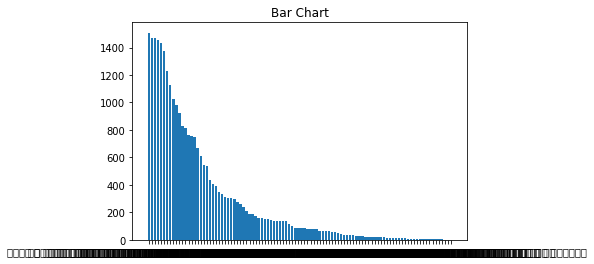

In [ ]:
plt.title("Bar Chart")
plt.bar(x, y)
plt.show()

In [ ]:
import statistics
statistics.median(y)

87.0

In [ ]:
delete_list = list()
for i, count in enumerate(y):
  if count < 87:
    delete_list.append(i)

subject_list = list()
for i, ti in enumerate(x):
  if i in delete_list:
    subject_list.append(ti) # 지워야할 제목의 리스트 생성

In [ ]:
for sl in subject_list:
  remove_index = df[df['title'] == sl].index
  print(remove_index)
  df = df.drop(remove_index)

Int64Index([17799, 17800, 17801, 17802, 17803, 17804, 17805, 17806, 17807,
            17808, 17809, 17810, 17811, 17812, 17813, 17814, 17815, 17816,
            17817, 17818, 17819, 17820, 17821, 17822, 17823, 17824, 17825,
            17826, 17827, 17828, 17829, 17830, 17831, 17832, 17833, 17834,
            17835, 17836, 17837, 17838, 17839, 17840, 17841, 17842, 17843,
            17844, 17845, 17846, 17847, 17848, 17849, 17850, 17851, 17852,
            17853, 17854, 17855, 17856, 17857, 17858, 17859, 17860, 17861,
            17862, 17863, 17864, 17865, 17866, 17867, 17868, 17869, 17870,
            17871, 17872, 17873, 17874, 17875, 17876, 17877, 17878, 17879,
            17880, 17881, 17882, 17883, 17884],
           dtype='int64')
Int64Index([494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506,
            507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519,
            520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532,
            533, 534

In [ ]:
df

,Comment,title
0,추가사항영상의 굽는 방식이 뼈등심을 굽는 방법의 정석은아닙니다하지만 가정에서 일반인...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
1,언더아머 가리는거 무엇,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
2,의도하고 언더아머 가리신거 같은뎈,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
3,언더아머 단속반입니다그렇게 가린다고 모를줄 알았습니까영상이 훌륭해서 이번만 봐줍니다...,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
4,이건 잘못구우면 맛없네 이소리나옴구독자분들 정육왕님 처럼 잘 굽는것도 기술입니다 굿,이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록
...,...,...
28277,새우튀김 맛있겠어요잘 배우고 갑니다만구독 꾹꾹제체널도 응원 부탁드려요,바삭 일식집 새우튀김고로모아게의 전 과정
28278,기름 뭐라하시는지 안들려서 그런데 뭐라하신건가요,바삭 일식집 새우튀김고로모아게의 전 과정
28279,말이 너무나 빨라서 이해하기가 어렵네요 화면도 가까이에서 보여죘으면합니다,바삭 일식집 새우튀김고로모아게의 전 과정
28280,이것 보다 더 잘 설명한 영상은 없는것 같습니다 너무너무 감사합니다,바삭 일식집 새우튀김고로모아게의 전 과정


In [ ]:
document = df['Comment']
summary = df['title']

### Preprocessing

In [ ]:
# for decoder sequence
summary = summary.apply(lambda x: '<go> ' + x + ' <stop>')
summary.head()

0    <go> 이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록 <stop>
1    <go> 이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록 <stop>
2    <go> 이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록 <stop>
3    <go> 이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록 <stop>
4    <go> 이 스테이크 부위를 대중들이 더 맛있게 드실 수 있도록 <stop>
Name: title, dtype: object

#### Tokenizing the texts into integer tokens

In [ ]:
# since < and > from default tokens cannot be removed
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
unk_token = '<unk>'

In [ ]:
document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=unk_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=unk_token)


In [ ]:
document_tokenizer.fit_on_texts(document)
summary_tokenizer.fit_on_texts(summary)

In [ ]:
inputs = document_tokenizer.texts_to_sequences(document)
targets = summary_tokenizer.texts_to_sequences(summary)
len(inputs), len(targets)


(26800, 26800)

In [ ]:
summary_tokenizer.texts_to_sequences(["간장게장"])

[[157]]

In [ ]:
summary_tokenizer.sequences_to_texts([[15]])

['요리']

In [ ]:
encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(71771, 258)

#### Obtaining insights on lengths for defining maxlen

In [ ]:
document

0        추가사항영상의 굽는 방식이 뼈등심을 굽는 방법의 정석은아닙니다하지만 가정에서 일반인...
1                                            언더아머 가리는거 무엇 
2                                       의도하고 언더아머 가리신거 같은뎈
3        언더아머 단속반입니다그렇게 가린다고 모를줄 알았습니까영상이 훌륭해서 이번만 봐줍니다...
4         이건 잘못구우면 맛없네 이소리나옴구독자분들 정육왕님  처럼 잘 굽는것도 기술입니다  굿
                               ...                        
28277            새우튀김 맛있겠어요잘 배우고  갑니다만구독 꾹꾹제체널도  응원  부탁드려요
28278                           기름 뭐라하시는지 안들려서 그런데 뭐라하신건가요
28279             말이 너무나 빨라서 이해하기가 어렵네요 화면도 가까이에서 보여죘으면합니다
28280               이것 보다 더 잘 설명한 영상은 없는것 같습니다  너무너무 감사합니다
28281    그럼 텐푸라가 일본음식이지 포르투갈 음식이라는건가짜장면 짬뽕은 한국음식이라고 우기는...
Name: Comment, Length: 26800, dtype: object

In [ ]:
document_lengths = pd.Series([len(x) for x in document])
summary_lengths = pd.Series([len(x) for x in summary])
print(document_lengths, summary_lengths)

0        303
1         14
2         18
3         55
4         48
        ... 
26795     41
26796     26
26797     40
26798     38
26799     50
Length: 26800, dtype: int64 0        42
1        42
2        42
3        42
4        42
         ..
26795    35
26796    35
26797    35
26798    35
26799    35
Length: 26800, dtype: int64


In [ ]:
document_lengths.describe()

count    26800.000000
mean        30.142537
std         37.000684
min          1.000000
25%         12.000000
50%         20.000000
75%         36.000000
max       1412.000000
dtype: float64

In [ ]:
summary_lengths.describe()

count    26800.000000
mean        40.672388
std         13.886701
min         22.000000
25%         30.000000
50%         38.000000
75%         55.000000
max         67.000000
dtype: float64

In [ ]:
# maxlen
# taking values > and round figured to 75th percentile
# at the same time not leaving high variance
encoder_maxlen = 40
decoder_maxlen = 60

#### Padding/Truncating sequences for identical sequence lengths

In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

### Creating dataset pipeline

In [ ]:
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)
print("target", targets.shape)
print("inputs", inputs.shape)

target (26800, 60)
inputs (26800, 40)


In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 16

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
len(list(dataset))

1675

### Positional Encoding for adding notion of position among words as unlike RNN this is non-directional

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


### Masking

- Padding mask for masking "pad" sequences
- Lookahead mask for masking future words from contributing in prediction of current words in self attention

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

### Building the Model

#### Scaled Dot Product

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### Multi-Headed Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

### Feed Forward Network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#### Fundamental Unit of Transformer encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


#### Fundamental Unit of Transformer decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


#### Encoder consisting of multiple EncoderLayer(s)

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x


#### Decoder consisting of multiple DecoderLayer(s)

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


#### Finally, the Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


### Training

In [ ]:
# hyper-params
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
EPOCHS = 1

#### Adam optimizer with custom learning rate scheduling

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#### Defining losses and other metrics 

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

#### Transformer

In [ ]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=encoder_vocab_size, 
    pe_target=decoder_vocab_size,
)

#### Masks

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask


#### Checkpoints

In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

#### Training steps

In [ ]:
@tf.function
def train_step(inp, tar):
    # print(tar[20])
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    print("tar_inp", tar_inp)
    print("tar_real",tar_real)
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
   # print("encpadd", enc_padding_mask)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

### Inference

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        # print(inp.shape, tar.shape)
        train_step(inp, tar)
        if batch % 429 == 0:
          print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
      
    # if (epoch + 1) % 5 == 0:
    #     ckpt_save_path = ckpt_manager.save()
    #     print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

tar_inp Tensor("strided_slice:0", shape=(16, 59), dtype=int32)
tar_real Tensor("strided_slice_1:0", shape=(16, 59), dtype=int32)
tar_inp Tensor("strided_slice:0", shape=(16, 59), dtype=int32)
tar_real Tensor("strided_slice_1:0", shape=(16, 59), dtype=int32)
Epoch 1 Batch 0 Loss 5.8828
Epoch 1 Batch 429 Loss 4.2519
Epoch 1 Batch 858 Loss 2.6824
Epoch 1 Batch 1287 Loss 1.9718
Epoch 1 Loss 1.6337
Time taken for 1 epoch: 175.02994418144226 secs



#### Predicting one word at a time at the decoder and appending it to the output; then taking the complete sequence as an input to the decoder and repeating until maxlen or stop keyword appears

In [ ]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["<go>"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["<stop>"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [ ]:
def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return summary_tokenizer.sequences_to_texts(summarized) # since there is just one translated document

In [ ]:
summarize( 
    "모든 갑각류가 간장에 절여지는 날까지 참참참"
)

['한국식 중식 레시피']

In [ ]:
summarize( 
    "간장게장"
)

['한국식 중식 레시피']